In [1]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from tqdm import tqdm, trange

# Numpyro
import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, init_to_feasible, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
from jax import random
import jax.numpy as jnp

# check versions
print(numpyro.__version__)
print(jax.__version__)
print(torch.__version__)
from platform import python_version
print(python_version())

0.10.1
0.3.25
1.12.1
3.8.16


In [2]:
# set device
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
args = {"seed": 0,
        
        # architecture
        "input_dim": 80,
        "hidden_dim": 60,
        "z_dim": 40,
        
        # VAE setup
        "n_epochs": 400,      
        "batch_size": 1000,
        
        # MCMC setup
        "num_warmup": 5000,
        "num_samples": 50000,
        "num_chains": 3,
        "thinning": 1,
        "true_ls": 0.2
       }

## GP priors

In [4]:
def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = z.reshape(z.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)

def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

def GP(x, jitter=1e-5, var=1.0, length=None, y=None, noise=False, gp_kernel=exp_sq_kernel):

    if length==None:  
        length = numpyro.sample("length", npdist.Uniform(0.01,0.99)) 
            
    k = gp_kernel(x, x, var, length, jitter)
    
    if noise==False:
        y = numpyro.sample("y",  npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))
        f = numpyro.sample("f", npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        y = numpyro.sample("y", npdist.Normal(f, sigma), obs=y)
    
    ls = numpyro.deterministic("ls", jnp.array([length]))

In [5]:
class GP1D(Dataset):
    def __init__(self, n_dataPoints=400, 
                       n_samples=10000, 
                       x_lim_low = 0, 
                       x_lim_high = 1,
                       ls = None
                 ): 
        self.n_dataPoints = n_dataPoints
        self.n_samples = n_samples
        self.x_lim_low = x_lim_low
        self.x_lim_high = x_lim_high
        self.ls = ls
        self.x, self.y, self.ls = self.__simulatedata__()
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx=0):
        return(self.x[idx], self.y[idx], self.ls[idx])

    def __simulatedata__(self):
        rng_key = rnd.randint(0, 912393890428)
        rng_key, _ = random.split(random.PRNGKey(rng_key))
        x = np.linspace(self.x_lim_low, self.x_lim_high, self.n_dataPoints)   
        gp_predictive = Predictive(GP, num_samples=self.n_samples)  
        all_draws = gp_predictive(rng_key, x=x, gp_kernel = exp_sq_kernel, jitter=1e-6, length=self.ls)

        ls_draws = np.array(all_draws['ls'])
        gp_draws = np.array(all_draws['y'])
        
        return (x.repeat(self.n_samples).reshape(x.shape[0], self.n_samples).transpose(), gp_draws, ls_draws)

## CVAE architecture

In [6]:
class Encoder(nn.Module):
    ''' This the encoder part of CVAE
    '''
    def __init__(self, input_dim, hidden_dim, z_dim, conditional):
        super().__init__()
        self.conditional = conditional
        if self.conditional:
            input_dim = input_dim + 1
        
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.sd = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, x, c=None):
        if self.conditional:
            #c = c[:, None]
            x = torch.cat((x, c), dim=-1)

        #hidden = torch.tanh(self.linear(x))
        hidden = torch.relu(self.linear(x))
        z_mu = self.mu(hidden)
        z_sd = self.sd(hidden)
        return z_mu, z_sd


In [7]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self,z_dim, hidden_dim, input_dim,  conditional):
        super().__init__()
        
        self.conditional = conditional
        if self.conditional:
            z_dim = z_dim + 1
            
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z, c):
        if self.conditional:
            z = torch.cat((z, c), dim=-1)

        hidden = torch.relu(self.linear(z))
        pred = self.out(hidden)
        return pred

In [8]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim,
                 conditional=False):
        
        super().__init__()        
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, conditional) 
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, conditional)

    def reparameterize(self, z_mu, z_sd):
        '''During training random sample from the learned ZDIMS-dimensional
           normal distribution; during inference its mean.
        '''
        if self.training:
            std = torch.exp(z_sd / 2)
            eps = torch.randn_like(std)
            return (eps.mul(std).add_(z_mu))
        else:
            return z_mu

    def forward(self, x, c=None):
        z_mu, z_sd = self.encoder(x, c)
        x_sample = self.reparameterize(z_mu, z_sd)
        generated_x = self.decoder(x_sample, c)
        return generated_x, z_mu,z_sd

## Load VAE, CVAE

In [9]:
# 1) Model
input_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
z_dim = args["z_dim"]

In [10]:
import pickle
cwd = os.getcwd()

# =========== import CVAE ==============
model = VAE(input_dim, hidden_dim, z_dim, conditional=True)
#device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

model_save_name = 'PriorCVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"])+'_continuous.pt'
loss_train_name = 'PriorCVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"])+'_loss_train_continuous'
loss_test_name =  'PriorCVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"])+'_loss_test_continuous'
print(model_save_name) 
print(loss_train_name) 
print(loss_test_name)

loss_train_name = cwd +"/trained_models/" + loss_train_name
loss_test_name = cwd + "/trained_models/" + loss_test_name

PATH = cwd + F"/trained_models/{model_save_name}" 

model.load_state_dict(torch.load(PATH))
model_cvae = model
del model
    
with open(loss_train_name, "rb") as fp:   
    loss_history_train_cvae = pickle.load(fp)
with open(loss_test_name, "rb") as fp:   
    loss_history_test_cvae = pickle.load(fp)

# =========== import VAE ==============
model = VAE(input_dim, hidden_dim, z_dim, conditional=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

model_save_name = 'PriorVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"])+'_continuous.pt'
loss_train_name = 'PriorVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"])+'_loss_train_continuous'
loss_test_name =  'PriorVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"])+'_loss_test_continuous'
print(model_save_name) 
print(loss_train_name) 
print(loss_test_name) 

PATH = cwd + F"/trained_models/{model_save_name}" 

loss_train_name = cwd +"/trained_models/" + loss_train_name
loss_test_name = cwd + "/trained_models/" + loss_test_name

model.load_state_dict(torch.load(PATH))
model_vae = model
del model
    
with open(loss_train_name, "rb") as fp:   
    loss_history_train_vae = pickle.load(fp)
with open(loss_test_name, "rb") as fp:   
    loss_history_test_vae = pickle.load(fp)

PriorCVAE_gp1d_n80_h60_z40_epochs400_b1000_continuous.pt
PriorCVAE_gp1d_n80_h60_z40_epochs400_b1000_loss_train_continuous
PriorCVAE_gp1d_n80_h60_z40_epochs400_b1000_loss_test_continuous
PriorVAE_gp1d_n80_h60_z40_epochs400_b1000_continuous.pt
PriorVAE_gp1d_n80_h60_z40_epochs400_b1000_loss_train_continuous
PriorVAE_gp1d_n80_h60_z40_epochs400_b1000_loss_test_continuous


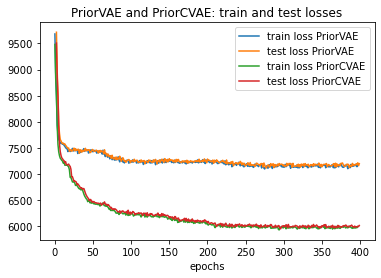

In [11]:
start_ind = 2

plt.figure()
plt.plot(np.arange(len(loss_history_train_vae[start_ind:])), loss_history_train_vae[start_ind:], label="train loss PriorVAE")
plt.plot(np.arange(len(loss_history_test_vae[start_ind:]))+2, loss_history_test_vae[start_ind:], label="test loss PriorVAE")

plt.plot(np.arange(len(loss_history_train_cvae[start_ind:])), loss_history_train_cvae[start_ind:], label="train loss PriorCVAE")
plt.plot(np.arange(len(loss_history_test_cvae[start_ind:]))+2, loss_history_test_cvae[start_ind:], label="test loss PriorCVAE")

plt.xlabel("epochs")
#plt.ylabel("Train and test errors")
plt.legend()
plt.title("PriorVAE and PriorCVAE: train and test losses")
#plt.show()

n = args["input_dim"]
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_VAE_CVAE_losses.pdf'.format(n))

## Visual diagnostics of how well we have learnt

In [145]:
def MMD(x, y, kernel="multiscale"):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
    return torch.mean(XX + YY - 2. * XY)

In [146]:
def demo_plots(conditional =False, 
               ttl1="GP priors to encode",
               ttl2="Priors learnt by VAE", 
               ylbl1='$y=f_{GP}(x)$', 
               ylbl2='$y=f_{VAE}(x)$', 
               ls=None,
               model=model_cvae):

    n_samps = 100000
    if conditional == True:
        dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=n_samps, ls=ls)
        ttl2="Priors learnt by CVAE"
        ylbl2='$y=f_{CVAE}(x)$'
    else:
        dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=n_samps, ls=ls)    

    gp_draws = dataset.y
    x = dataset.x[0,:]
    gp_draws = gp_draws.transpose()

    model.eval() # model in eval mode
    z = torch.randn(n_samps, z_dim).to(device) # random draw

    if conditional == True:
        c = torch.ones(n_samps) * ls
        c = c[:, None]
        with torch.no_grad():
            vae_draws = model.decoder(z, c).numpy().transpose()
    else:
        with torch.no_grad():
            vae_draws = model.decoder(z, c=None).numpy().transpose()

    mean_gp = np.nanmean(gp_draws, axis=1)
    q025_gp = np.quantile(gp_draws, 0.025, axis=1)
    q975_gp = np.quantile(gp_draws, 0.975, axis=1)
    #print(mean_gp.shape)

    mean_vae = np.nanmean(vae_draws, axis=1)
    q025_vae = np.quantile(vae_draws, 0.025, axis=1)
    q975_vae = np.quantile(vae_draws, 0.975, axis=1)

    #print("q025: ")
    #print(q025_gp)
    #print(q025_vae)
    #print("q975: ")
    #print(q975_gp)
    #print(q975_vae)

    # plot results
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

    _min, _max = -3, 3
    lines_alpha_gp = 0.5
    lines_alpha_vae = 0.5
    N_lines = 20

    if ls==None:
        ttl = ttl1
    else:
        ttl = ttl1+ ", ls=" + str(ls)
    ylbl = ylbl1

    for j in range(N_lines):
        itr = int(gp_draws.shape[1]/N_lines)
        axs[0].plot(x, gp_draws[:,j*itr], alpha=lines_alpha_gp, label="")

    axs[0].plot(x, gp_draws[:,0], alpha=lines_alpha_gp, color="darkgreen", label="GP draws")  
    axs[0].fill_between(x, q025_gp[0], q975_gp[1], alpha=0.1, interpolate=True, label="95% BCI")
    axs[0].plot(x, mean_gp, label="mean")
    axs[0].legend(loc=4)
    axs[0].set_ylim([_min, _max])
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel(ylbl)
    axs[0].set_title(ttl)

    if ls==None:
        tt2 = ttl2
    else:
        tt2 = ttl2+ ", ls=" + str(ls)
    ylbl=ylbl2

    for j in range(N_lines):
        itr = int(vae_draws.shape[1]/N_lines)
        axs[1].plot(x, vae_draws[:,j*itr], alpha=lines_alpha_vae, label="")

    axs[1].plot(x, vae_draws[:,0], alpha=lines_alpha_vae, color="darkgreen", label="VAE draws")  
    axs[1].fill_between(x, q025_vae[0], q975_vae[1], alpha=0.1, interpolate=True, label="95% BCI")
    axs[1].plot(x, mean_vae, label="mean")
    axs[1].legend(loc=4)
    axs[1].set_ylim([_min, _max])
    axs[1].set_xlabel('$x$')
    axs[1].set_ylabel(ylbl)
    axs[1].set_title(tt2)

    axs[2].fill_between(x, q025_gp[0], q975_gp[1], alpha=0.1, interpolate=True, label="95% BCI")
    axs[2].plot(x, mean_gp, label="mean")
    axs[2].fill_between(x, q025_vae[0], q975_vae[1], alpha=0.1, interpolate=True, label="95% BCI")
    axs[2].plot(x, mean_vae, label="mean")
    axs[2].legend(loc=4)
    axs[2].set_ylim([_min, _max])

    plt.show()

    m_vae = np.cov((vae_draws))
    m_gp = np.cov((gp_draws))
    print('Frobenius norm = ' + str(np.linalg.norm(m_gp - m_vae,  'fro')))
    
    gg = torch.from_numpy(gp_draws)
    vv = torch.from_numpy(vae_draws)
    print('MMD, multiscale = ' + str(MMD(gg, vv)))
    print('MMD, rbf = ' + str(MMD(gg, vv, "rbf")))
    
    cmap_choice = 'inferno'
    
    gp_cm_ttl = 'GP covariance matrix'
    if ls is not None:
        gp_cm_ttl = gp_cm_ttl + ', c='+ str(ls)
    vae_cm_ttl = 'VAE covariance matrix'
    if ls is not None:
        vae_cm_ttl = vae_cm_ttl +', c='+ str(ls)


    #'plasma'
    #'inferno'
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
    axs[0].imshow(m_gp, cmap=cmap_choice)
    axs[0].axis('off')

    axs[0].set_title(gp_cm_ttl)
    #axs[0].set_title('GP covariance matrix, c=' + str(ls))

    axs[1].imshow(m_vae, cmap=cmap_choice)
    axs[1].axis('off')
    axs[1].set_title(vae_cm_ttl)

    plt.show()
    
    return (gp_draws, vae_draws)

def psd_plot(gp_draws, vae_draws):
    # power spectral density
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    N_lines = 100
    itr = int(gp_draws.shape[1]/N_lines)
    for j in range(N_lines):
        axs[0].psd(gp_draws[:,j*itr], color='blue', alpha=0.3, label='gp')
        axs[0].set_ylim(-100, 20)
        axs[0].set_title("GP - PSD")
        axs[1].psd(vae_draws[:,j*itr], color='darkorange', alpha=0.6, label='vae')    
        axs[1].set_ylim(-100, 20)
        axs[1].set_title("VAE - PSD")
    plt.show()

In [147]:
# there plots create motivation:
# 1).     unceratinty interval does not exactly match the oroginal one. This is due to the MSE loss. 
#         We can change it either to likelihood with variance which is not one, or use beta-VAE, or MMD.
# 2).     VAE has learnt the best draws with ls=0.5 (Frob norm = 5.7)
# 3), 4). VAE has not learnt draws with ls values on the edge of the interval well (Frob norm = 20.3)

In [148]:
plt.rcParams['figure.dpi'] = 50
plt.rcParams['savefig.dpi'] = 50

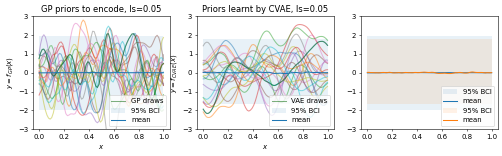

Frobenius norm = 14.434770804991276
MMD, multiscale = tensor(0.1001)
MMD, rbf = tensor(0.1000)


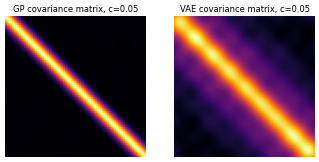

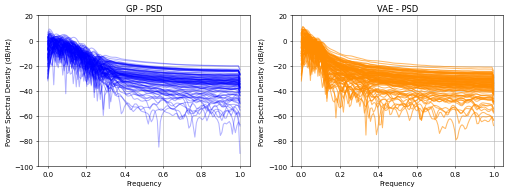

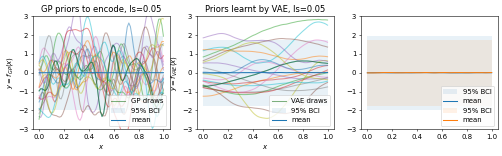

Frobenius norm = 45.366187699408826
MMD, multiscale = tensor(0.1013)
MMD, rbf = tensor(0.1156)


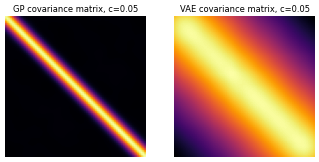

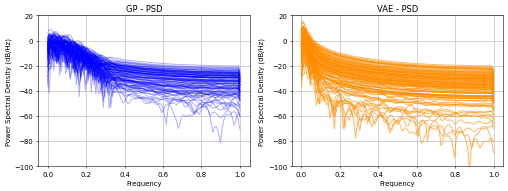

In [155]:
gp_draws, cvae_draws = demo_plots(conditional=True, ls=0.05, model=model_cvae)
psd_plot(gp_draws, cvae_draws)

gp_draws, vae_draws = demo_plots(conditional=False, ls=0.05, model=model_vae)
psd_plot(gp_draws, vae_draws)

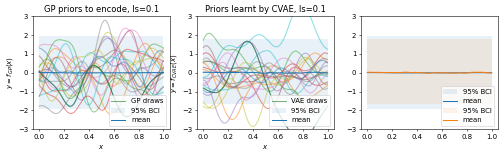

Frobenius norm = 7.628487436954558
MMD, multiscale = tensor(0.1002)
MMD, rbf = tensor(0.1001)


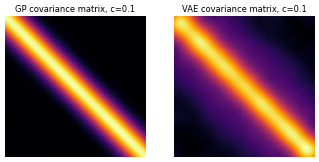

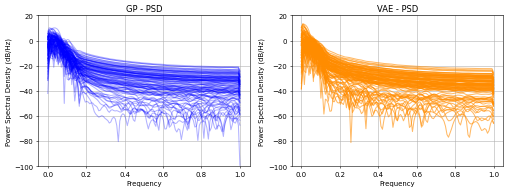

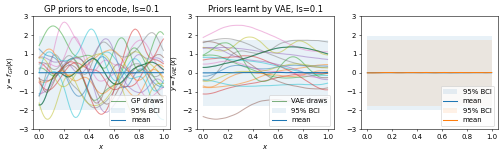

Frobenius norm = 37.494771517898926
MMD, multiscale = tensor(0.1013)
MMD, rbf = tensor(0.1158)


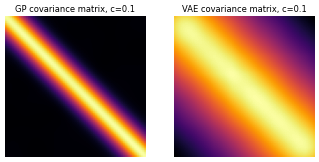

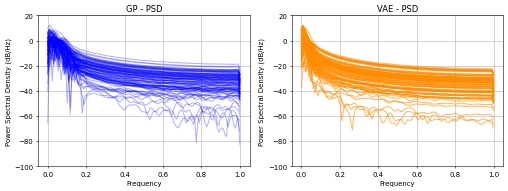

In [156]:
gp_draws, cvae_draws = demo_plots(conditional=True, ls=0.1, model=model_cvae)
psd_plot(gp_draws, cvae_draws)

gp_draws, vae_draws = demo_plots(conditional=False, ls=0.1, model=model_vae)
psd_plot(gp_draws, vae_draws)

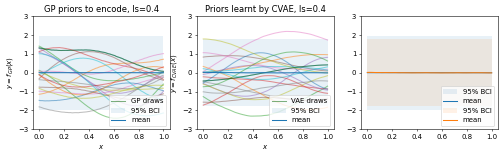

Frobenius norm = 6.425648401087303
MMD, multiscale = tensor(0.1027)
MMD, rbf = tensor(0.1350)


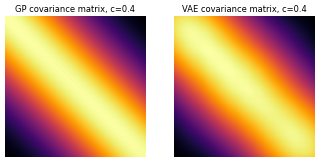

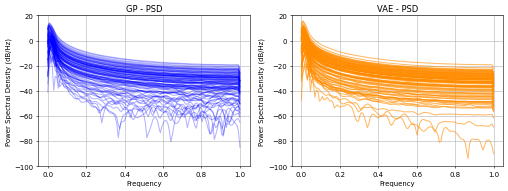

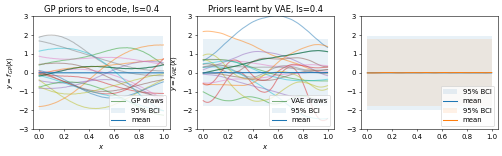

Frobenius norm = 8.293032441291425
MMD, multiscale = tensor(0.1023)
MMD, rbf = tensor(0.1276)


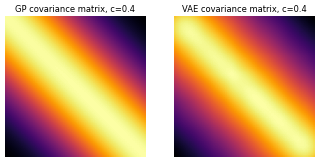

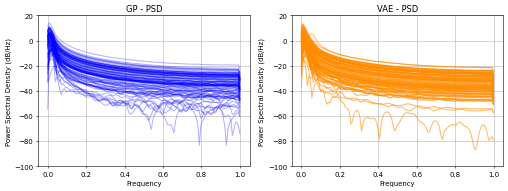

In [157]:
gp_draws, cvae_draws = demo_plots(conditional=True, ls=0.4, model=model_cvae)
psd_plot(gp_draws, cvae_draws)

gp_draws, vae_draws = demo_plots(conditional=False, ls=0.4, model=model_vae)
psd_plot(gp_draws, vae_draws)

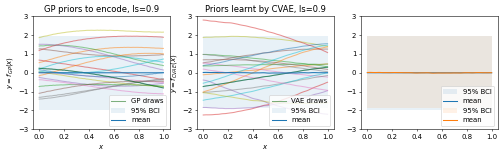

Frobenius norm = 1.9928777219025504
MMD, multiscale = tensor(0.1106)
MMD, rbf = tensor(0.2591)


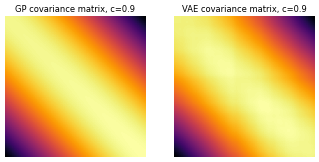

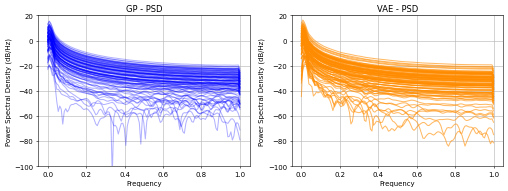

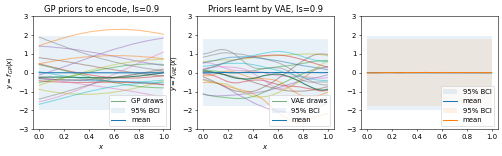

Frobenius norm = 22.944177129960767
MMD, multiscale = tensor(0.1062)
MMD, rbf = tensor(0.1914)


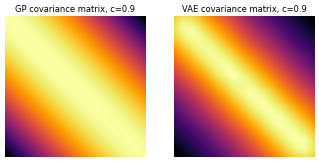

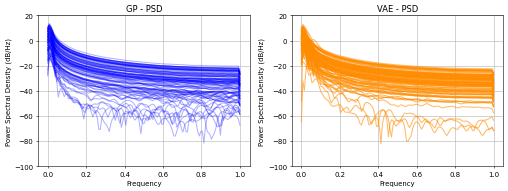

In [158]:
# 4).
gp_draws, cvae_draws = demo_plots(conditional=True, ls=0.9, model=model_cvae)
psd_plot(gp_draws, cvae_draws)

gp_draws, vae_draws = demo_plots(conditional=False, ls=0.9, model=model_vae)
psd_plot(gp_draws, vae_draws)

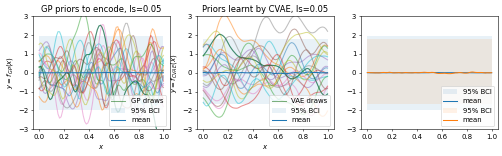

Frobenius norm = 14.486847522292802
MMD, multiscale = tensor(0.1001)
MMD, rbf = tensor(0.1000)


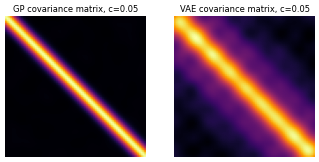

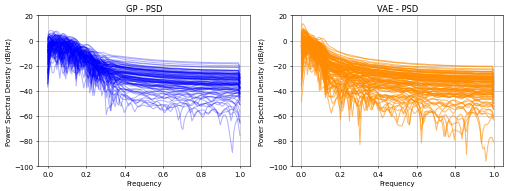

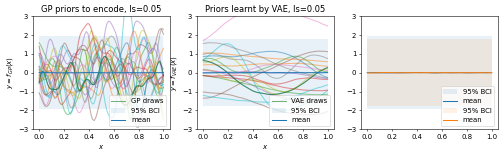

Frobenius norm = 45.218749037537094
MMD, multiscale = tensor(0.1012)
MMD, rbf = tensor(0.1155)


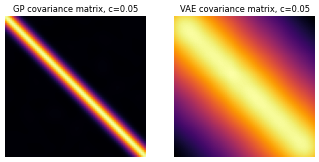

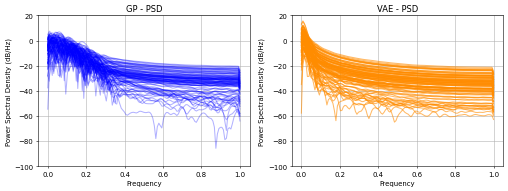

## Plots for paper

In [44]:
# lengthscale = 0.1 ------------------------
ls1 = 0.1 

n_samps = 100000
dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=n_samps, ls=ls1)

# GP
gp_draws_ls1 = dataset.y
x = dataset.x[0,:]
gp_draws_ls1 = gp_draws_ls1.transpose()

z = torch.randn(n_samps, z_dim).to(device) # random draw

# VAE
model_vae.eval() # model in eval mode
with torch.no_grad():
    vae_draws_ls1 = model_vae.decoder(z, c=None).numpy().transpose()

# CVAE
model_cvae.eval() # model in eval mode
c = torch.ones(n_samps) * ls1
c = c[:, None]
with torch.no_grad():
    cvae_draws_ls1 = model_cvae.decoder(z, c).numpy().transpose()

mean_gp_ls1 = np.nanmean(gp_draws_ls1, axis=1)
q025_gp_ls1 = np.quantile(gp_draws_ls1, 0.025, axis=1)
q975_gp_ls1 = np.quantile(gp_draws_ls1, 0.975, axis=1)

mean_vae_ls1 = np.nanmean(vae_draws_ls1, axis=1)
q025_vae_ls1 = np.quantile(vae_draws_ls1, 0.025, axis=1)
q975_vae_ls1 = np.quantile(vae_draws_ls1, 0.975, axis=1)

mean_cvae_ls1 = np.nanmean(cvae_draws_ls1, axis=1)
q025_cvae_ls1 = np.quantile(cvae_draws_ls1, 0.025, axis=1)
q975_cvae_ls1 = np.quantile(cvae_draws_ls1, 0.975, axis=1)

In [45]:
# lengthscale = 0.9 ------------------------
ls2 = 0.9

n_samps = 100000
dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=n_samps, ls=ls2)

# GP
gp_draws_ls2 = dataset.y
x = dataset.x[0,:]
gp_draws_ls2 = gp_draws_ls2.transpose()

z = torch.randn(n_samps, z_dim).to(device) # random draw

# VAE
model_vae.eval() # model in eval mode
with torch.no_grad():
    vae_draws_ls2 = model_vae.decoder(z, c=None).numpy().transpose()

# CVAE
model_cvae.eval() # model in eval mode
c = torch.ones(n_samps) * ls2
c = c[:, None]
with torch.no_grad():
    cvae_draws_ls2 = model_cvae.decoder(z, c).numpy().transpose()

mean_gp_ls2 = np.nanmean(gp_draws_ls2, axis=1)
q025_gp_ls2 = np.quantile(gp_draws_ls2, 0.025, axis=1)
q975_gp_ls2 = np.quantile(gp_draws_ls2, 0.975, axis=1)

mean_vae_ls2 = np.nanmean(vae_draws_ls2, axis=1)
q025_vae_ls2 = np.quantile(vae_draws_ls2, 0.025, axis=1)
q975_vae_ls2 = np.quantile(vae_draws_ls2, 0.975, axis=1)

mean_cvae_ls2 = np.nanmean(cvae_draws_ls2, axis=1)
q025_cvae_ls2 = np.quantile(cvae_draws_ls2, 0.025, axis=1)
q975_cvae_ls2 = np.quantile(cvae_draws_ls2, 0.975, axis=1)

In [46]:
def plot_pair(gp_draws_ls1, gp_draws_ls2,
              ttl1="GP priors, $l=$" + str(ls1),
              ylbl1='$y=f_{GP}(x)$',
              ttl2="GP priors, $l=$" + str(ls2),
              ylbl2='$y=f_{GP}(x)$'
             ):
    
    mean_gp_ls1 = np.nanmean(gp_draws_ls1, axis=1)
    q025_gp_ls1 = np.quantile(gp_draws_ls1, 0.025, axis=1)
    q975_gp_ls1 = np.quantile(gp_draws_ls1, 0.975, axis=1)
    
    mean_gp_ls2 = np.nanmean(gp_draws_ls2, axis=1)
    q025_gp_ls2 = np.quantile(gp_draws_ls2, 0.025, axis=1)
    q975_gp_ls2 = np.quantile(gp_draws_ls2, 0.975, axis=1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    N_lines = 20
    lines_alpha_gp = 0.5
    _min, _max = -3, 3

    #ttl="GP priors, $ls=$" + str(ls1)
    #ylbl='$y=f_{GP}(x)$'
    
    for j in range(N_lines):
        axs[0].plot(x, gp_draws_ls1[:,j], alpha=lines_alpha_gp, label="", color="darkgreen", linewidth=0.8)
    axs[0].plot(x, gp_draws_ls1[:,0], alpha=lines_alpha_gp, color="darkgreen", label="draws", linewidth=0.8)  
    axs[0].fill_between(x, q025_gp_ls1[0], q975_gp_ls1[1], alpha=0.1, interpolate=True, label="95% BCI")
    axs[0].plot(x, mean_gp_ls1, label="mean")
    axs[0].legend(loc=4)
    axs[0].set_ylim([_min, _max])
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel(ylbl1)
    axs[0].set_title(ttl1)

    for j in range(N_lines):
        axs[1].plot(x, gp_draws_ls2[:,j], alpha=lines_alpha_gp, label="", color="darkgreen", linewidth=0.8)
    axs[1].plot(x, gp_draws_ls2[:,0], alpha=lines_alpha_gp, color="darkgreen", label="draws", linewidth=0.8)  
    axs[1].fill_between(x, q025_gp_ls2[0], q975_gp_ls2[1], alpha=0.1, interpolate=True, label="95% BCI")
    axs[1].plot(x, mean_gp_ls2, label="mean")
    axs[1].legend(loc=4)
    axs[1].set_ylim([_min, _max])
    axs[1].set_xlabel('$x$')
    axs[1].set_ylabel(ylbl2)
    axs[1].set_title(ttl2)

In [110]:
def plot_covs(gp_draws, vae_draws, 
              ttl1 = 'GP empirical covariance matrix,\n $l=$' + str(ls1),
              ttl2 = 'GP empirical covariance matrix,\n $l=$' + str(ls2),
             ):

    m_vae = np.cov((vae_draws))
    m_gp = np.cov((gp_draws))
    print(np.linalg.norm(m_gp - m_vae,  'fro'))

    cmap_choice = 'inferno'
    #cmap_choice = 'plasma'

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
    axs[0].imshow(m_gp, cmap=cmap_choice)
    axs[0].axis('off')
    axs[0].set_title(ttl1)

    axs[1].imshow(m_vae, cmap=cmap_choice)
    axs[1].axis('off')
    axs[1].set_title(ttl2)

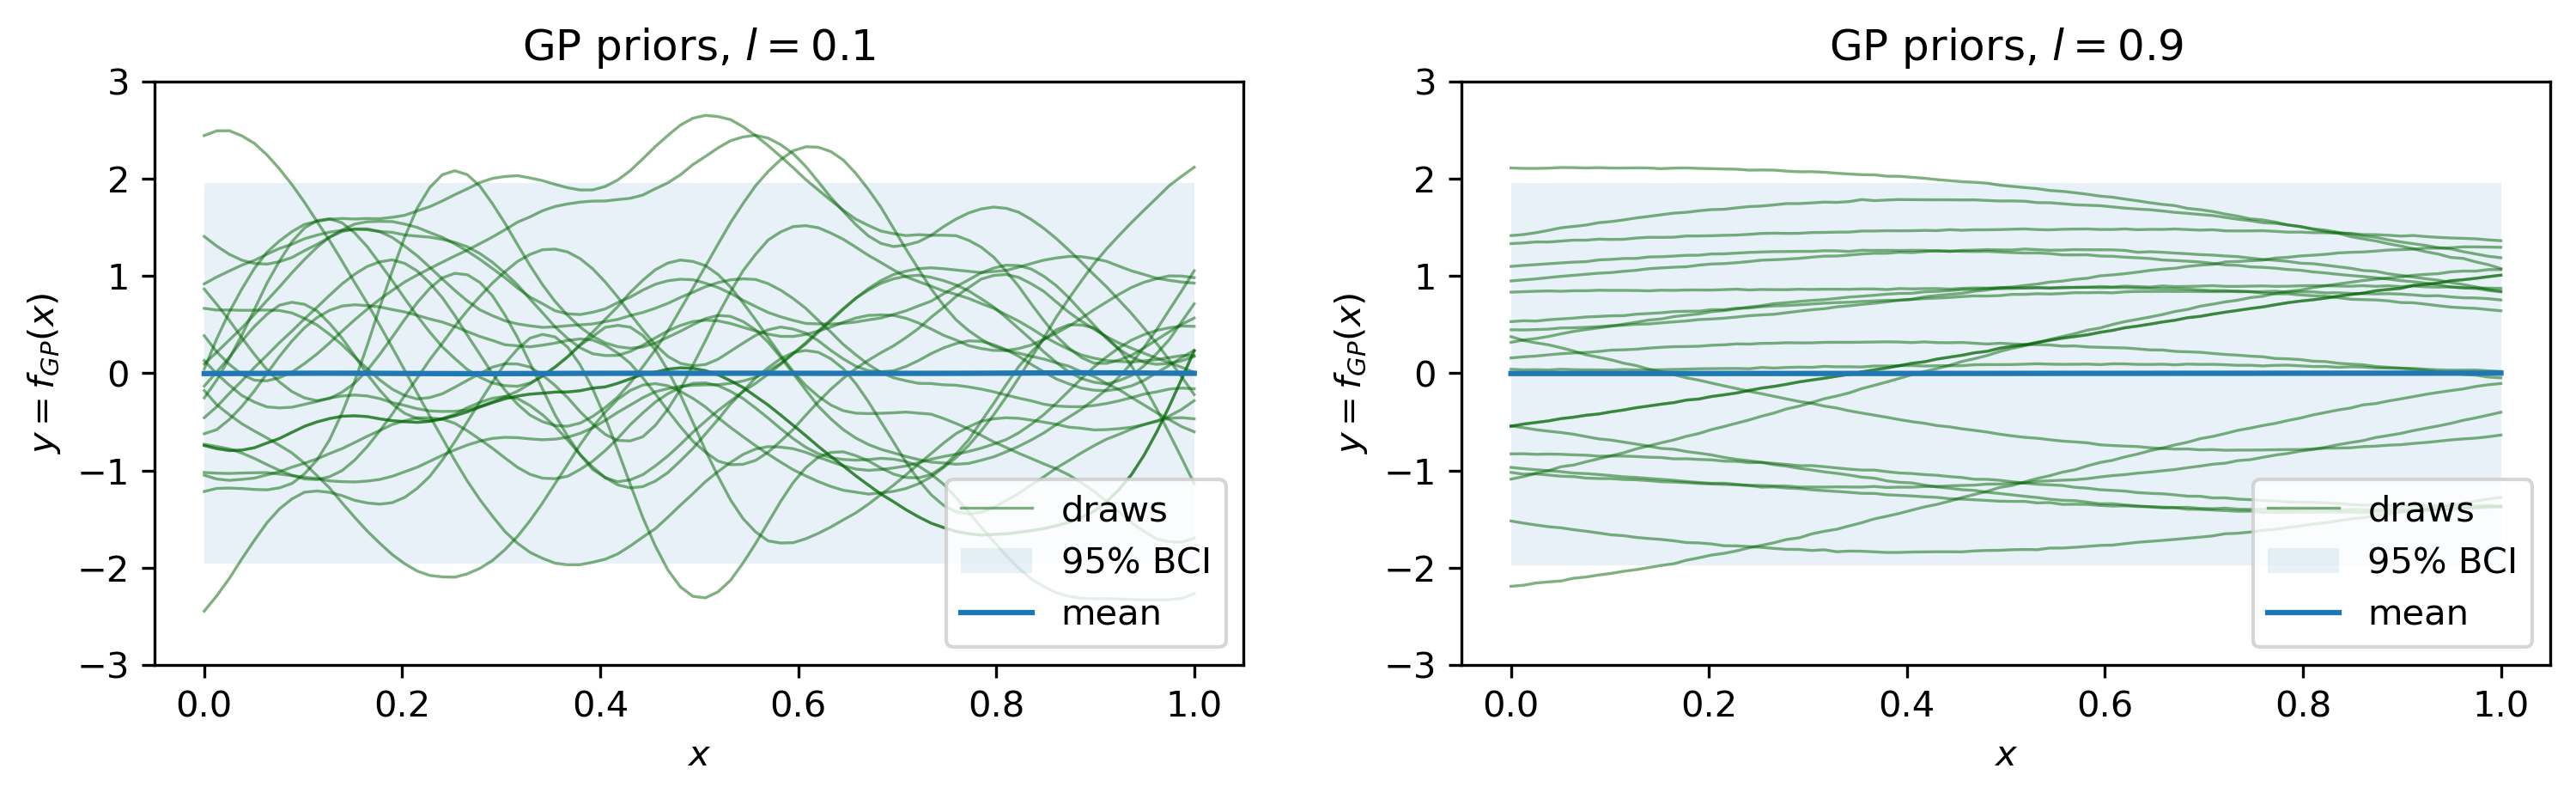

In [48]:
plot_pair(gp_draws_ls1, gp_draws_ls2)

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_GP_ls1_ls2_priors.pdf'.format(n))

59.15401814393017


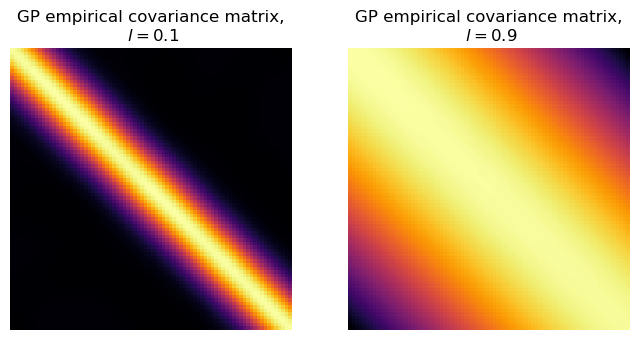

In [111]:
plot_covs(gp_draws_ls1, gp_draws_ls2)

#n = args["input_dim"]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_GP_ls1_ls2_cov_mats.pdf'.format(n))

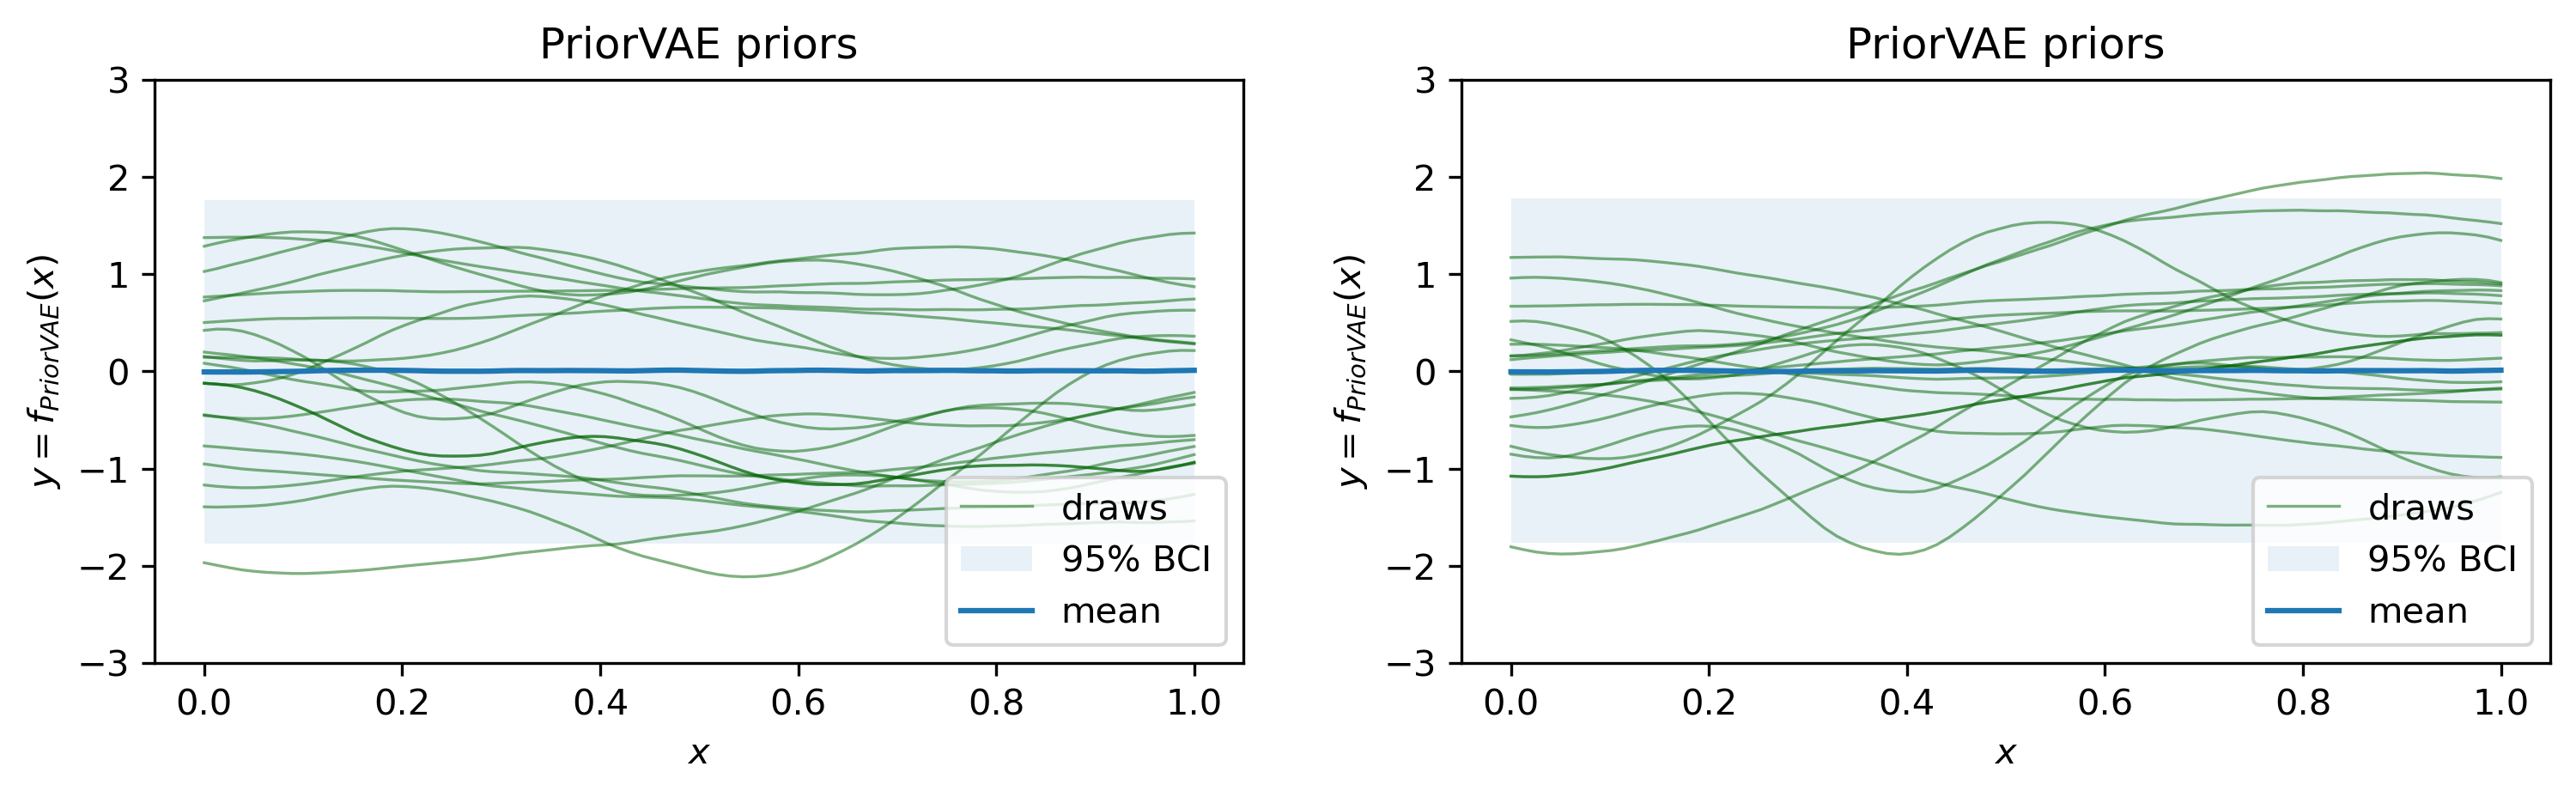

In [52]:
plot_pair(vae_draws_ls1, vae_draws_ls2, 
          ttl1="PriorVAE priors",
          ylbl1='$y=f_{PriorVAE}(x)$',
          ttl2="PriorVAE priors",
          ylbl2='$y=f_{PriorVAE}(x)$')

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('res/1d_n{}_VAE_ls1_ls2_priors.pdf'.format(n))

0.1766103393043754


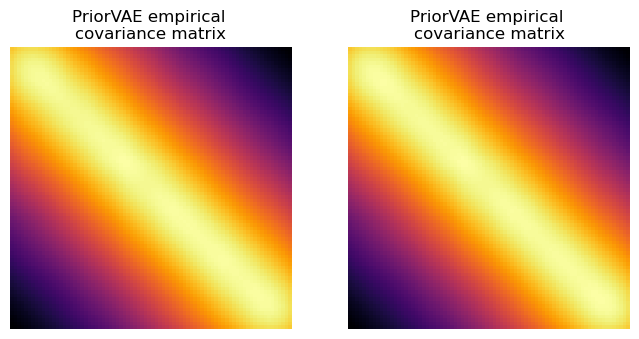

In [54]:
plot_covs(vae_draws_ls1, vae_draws_ls2, ttl1 = 'PriorVAE empirical \ncovariance matrix', ttl2 = 'PriorVAE empirical \ncovariance matrix')

#n = args["input_dim"]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_VAE_ls1_ls2_cov_mats.pdf'.format(n))

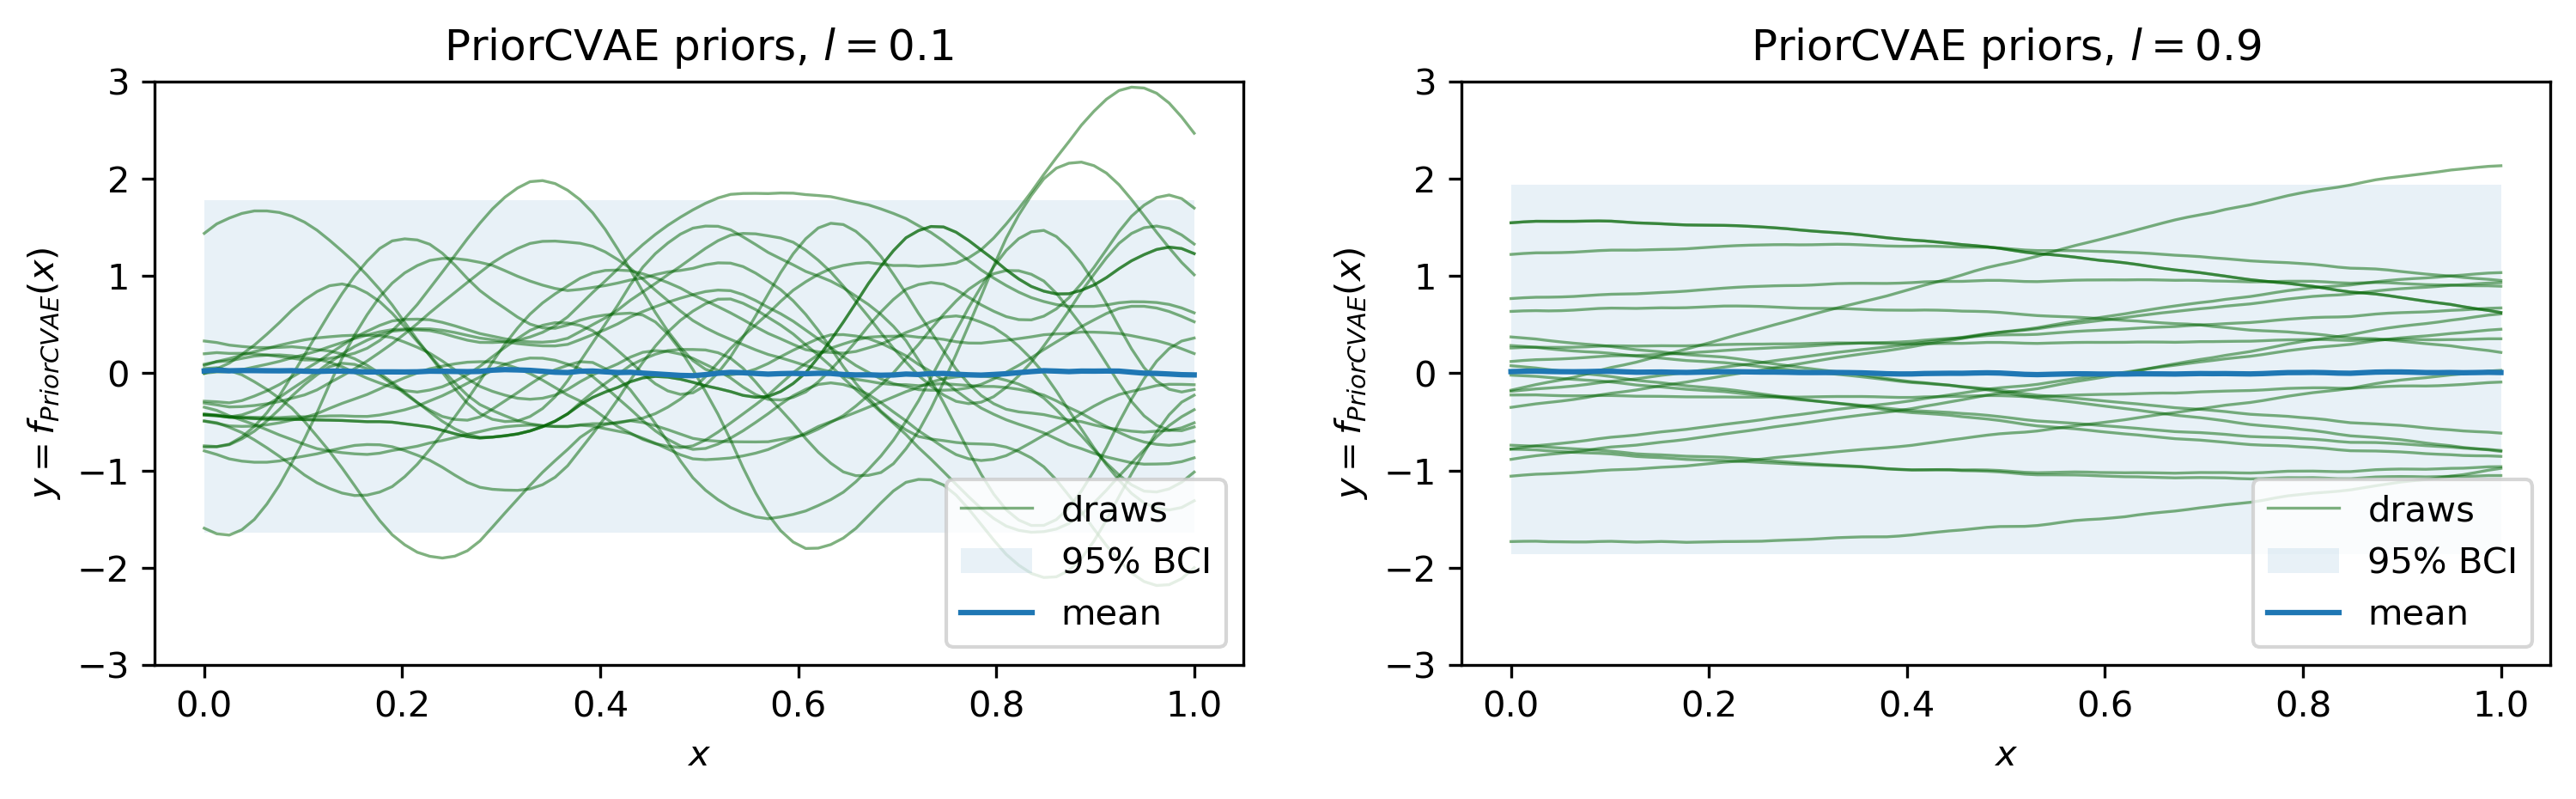

In [57]:
plot_pair(cvae_draws_ls1, cvae_draws_ls2, 
          ttl1="PriorCVAE priors, $l=$" + str(ls1),
          ylbl1='$y=f_{PriorCVAE}(x)$',
          ttl2="PriorCVAE priors, $l=$" + str(ls2),
          ylbl2='$y=f_{PriorCVAE}(x)$')

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('res/1d_n{}_CVAE_ls1_ls2_priors.pdf'.format(n))

52.056528160107035


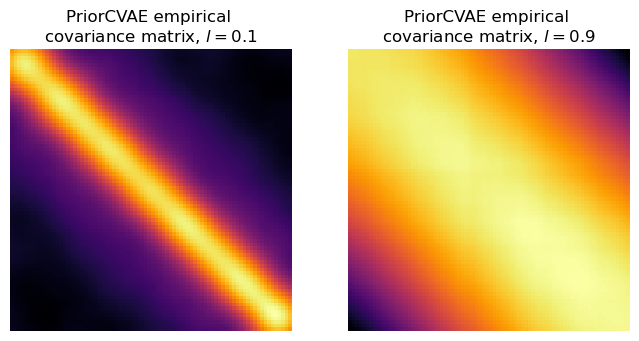

In [59]:
plot_covs(cvae_draws_ls1, cvae_draws_ls2, 
          ttl1 = 'PriorCVAE empirical \ncovariance matrix, $l=$' + str(ls1),
          ttl2 = 'PriorCVAE empirical \ncovariance matrix, $l=$' + str(ls2)
         )

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_CVAE_ls1_ls2_cov_mats.pdf'.format(n))

# Inference

## Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to ls=0.2')

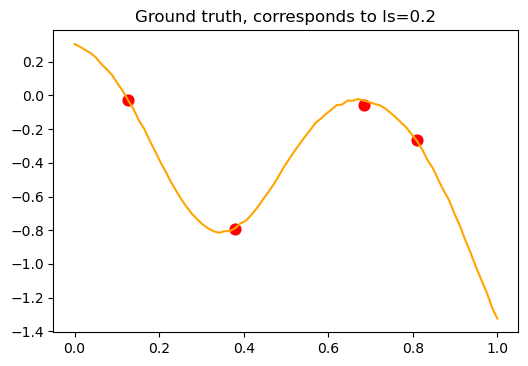

In [60]:
x = np.linspace(0, 1, args["input_dim"])   

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6, 
                      noise=True, length=args["true_ls"], var=1)

gp_draw = draws['f'].T
y_draw = draws['y'].T

obs_idx_lst = []
obs_idx_lst.append([10, 30, 54, 64]) # points correspond to n=80, ls=0.2, rng1
i = 0

# choose indices of data points for inference
obs_idx = jnp.array(obs_idx_lst[i])

y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

args['y_obs'] = y_obs
args['obs_idx'] = obs_idx
args['x_obs'] = x_obs

plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to ls=' + str(args["true_ls"]))

## Numpyro model

In [61]:
def c_decoder_numpy(z, W1, B1, W2, B2, c=None):
   
    def linear(z, W, B):
        lin_out = jnp.matmul(z, W) + B
        return lin_out

    if c is not None:
        c = jnp.array(c).reshape(1)
        z = jnp.concatenate([z, c], axis=0)

    hidden = jax.nn.relu(linear(z, W1, B1))
    out = linear(hidden, W2, B2)
    return out

        
def numpyro_model(z_dim, conditional=False,  y=None, obs_idx=None, c=None,):
    
    if c is None and conditional==True:
        c = numpyro.sample("c", npdist.Uniform(0.01,0.99))

    z = numpyro.sample("z", npdist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim))) 
    
    f = numpyro.deterministic("f", c_decoder_numpy(z, W1, B1, W2, B2, c))
    sigma = numpyro.sample("sigma", npdist.HalfNormal(0.1))

    if y is None: # durinig prediction
        y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))
    else: # during inference
        y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)

In [62]:
def run_mcmc_vae(rng_key, numpyro_model, args, verbose=True, c=None, conditional=False):
    start = time.time()

    #init_strategy = init_to_median(num_samples=10)
    init_strategy = init_to_feasible()
    kernel = NUTS(numpyro_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    start = time.time()
    mcmc.run(rng_key, args["z_dim"], conditional, args["y_obs"], args["obs_idx"], c )
    t_elapsed = time.time() - start
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)
    
    print("\nMCMC elapsed time:", round(t_elapsed), "s")
    ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
    r = np.mean(ss['f']['n_eff'])
    print("Average ESS for all VAE-GP effects : " + str(round(r)))

    return (mcmc, mcmc.get_samples(), t_elapsed)

## Inference on observed data - PriorCVAE

In [63]:
# decoder parameters

model_cvae = model_cvae.to('cpu')
decoder_dict = model_cvae.decoder.state_dict()
decoder_dict.keys()

W1 = decoder_dict['linear.weight'].T.numpy()
B1 = decoder_dict['linear.bias'].numpy()
W2 = decoder_dict['out.weight'].T.numpy()
B2 = decoder_dict['out.bias'].T.numpy()

print(W1.shape)
print(B1.shape)
print(W2.shape)
print(B2.shape)

(41, 60)
(60,)
(60, 80)
(80,)


/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_11134/2204076190.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484782168/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  B2 = decoder_dict['out.bias'].T.numpy()


In [64]:
rng_key =  random.PRNGKey(1)
rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_cvae, mcmc_cvae_samples, t_elapsed = run_mcmc_vae(rng_key_post, numpyro_model, args, conditional=True)

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.19      0.15      0.17      0.01      0.29   8250.37      1.00
      f[0]      0.17      0.48      0.25     -0.66      0.85  33806.96      1.00
      f[1]      0.16      0.50      0.25     -0.69      0.88  35230.74      1.00
      f[2]      0.15      0.49      0.23     -0.71      0.86  36039.26      1.00
      f[3]      0.14      0.47      0.21     -0.68      0.83  36316.95      1.00
      f[4]      0.11      0.44      0.18     -0.65      0.75  36088.70      1.00
      f[5]      0.09      0.39      0.15     -0.58      0.67  35291.08      1.00
      f[6]      0.07      0.33      0.11     -0.53      0.55  34255.25      1.00
      f[7]      0.04      0.27      0.08     -0.44      0.43  32272.02      1.00
      f[8]      0.01      0.21      0.04     -0.35      0.33  30340.07      1.00
      f[9]     -0.02      0.15      0.00     -0.27      0.22  29654.05      1.00
     f[10]     -0.05      0

Average ESS for all VAE-GP effects : 34725


In [65]:
mcmc_cvae_samples['c'].shape

(150000,)

(-2.0, 1.0)

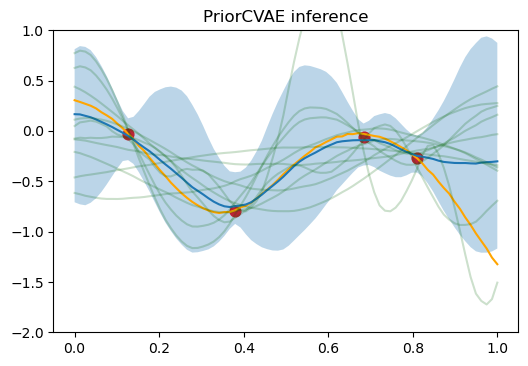

In [66]:
predictive = Predictive(numpyro_model, mcmc_cvae_samples)
predictions_cvae = predictive(rng_key_pred,  args["z_dim"], True, args["y_obs"], args["obs_idx"] )["f"]

mean_post_pred_cvae = jnp.mean(predictions_cvae, axis=0)
hpdi_post_pred_cvae = hpdi(predictions_cvae, 0.9)
percentiles_cvae = np.percentile(predictions_cvae, [5.0, 95.0], axis=0)

N_lines = 10
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_cvae, label="predicted mean VAE")

plt.fill_between(x, percentiles_cvae[0, :], percentiles_cvae[1, :], alpha=0.3, interpolate=True, label="CVAE posterior: 90% BCI")
for j in range(N_lines):
    itr = int(predictions_cvae.shape[0]/N_lines)
    #plt.plot(x, predictions_vae[j* itr,:], alpha=0.2, color="darkgreen", label="")
    plt.plot(x, predictions_cvae[j,:], alpha=0.2, color="darkgreen", label="")

plt.title('PriorCVAE inference')
#plt.legend(loc=1)
plt.ylim([-2, 1])


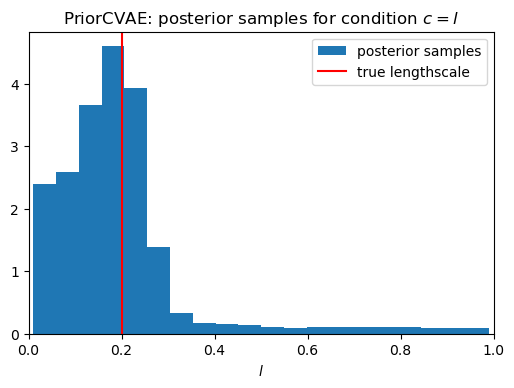

In [67]:
c_samps_cvae = mcmc_cvae_samples['c']
plt.hist(c_samps_cvae, density=True, label = 'posterior samples', bins=20)
plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('PriorCVAE: posterior samples for condition $c=l$')
plt.legend()
plt.xlabel('$l$')

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_continuous_inference_CVAE_ls.pdf'.format(n))

## Inference on observed data - PriorVAE

In [68]:
# decoder parameters

model_vae = model_vae.to('cpu')
decoder_dict = model_vae.decoder.state_dict()
decoder_dict.keys()

W1 = decoder_dict['linear.weight'].T.numpy()
B1 = decoder_dict['linear.bias'].numpy()
W2 = decoder_dict['out.weight'].T.numpy()
B2 = decoder_dict['out.bias'].T.numpy()

print(W1.shape)
print(B1.shape)
print(W2.shape)
print(B2.shape)

(40, 60)
(60,)
(60, 80)
(80,)


In [69]:
rng_key =  random.PRNGKey(1)
rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, numpyro_model, args, conditional=False)

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      0.04      0.28      0.06     -0.41      0.45  20208.72      1.00
      f[1]      0.05      0.28      0.07     -0.40      0.48  20090.85      1.00
      f[2]      0.05      0.28      0.07     -0.42      0.45  20120.42      1.00
      f[3]      0.04      0.27      0.06     -0.41      0.44  20354.23      1.00
      f[4]      0.04      0.26      0.06     -0.38      0.42  20892.15      1.00
      f[5]      0.03      0.24      0.05     -0.35      0.40  21904.52      1.00
      f[6]      0.02      0.22      0.04     -0.33      0.35  24246.33      1.00
      f[7]      0.01      0.19      0.02     -0.30      0.31  28797.68      1.00
      f[8]     -0.01      0.16      0.01     -0.28      0.25  38165.50      1.00
      f[9]     -0.03      0.14     -0.01     -0.26      0.19  59707.33      1.00
     f[10]     -0.06      0.13     -0.04     -0.28      0.14  86917.58      1.00
     f[11]     -0.09      0

Average ESS for all VAE-GP effects : 31115


(-2.0, 1.0)

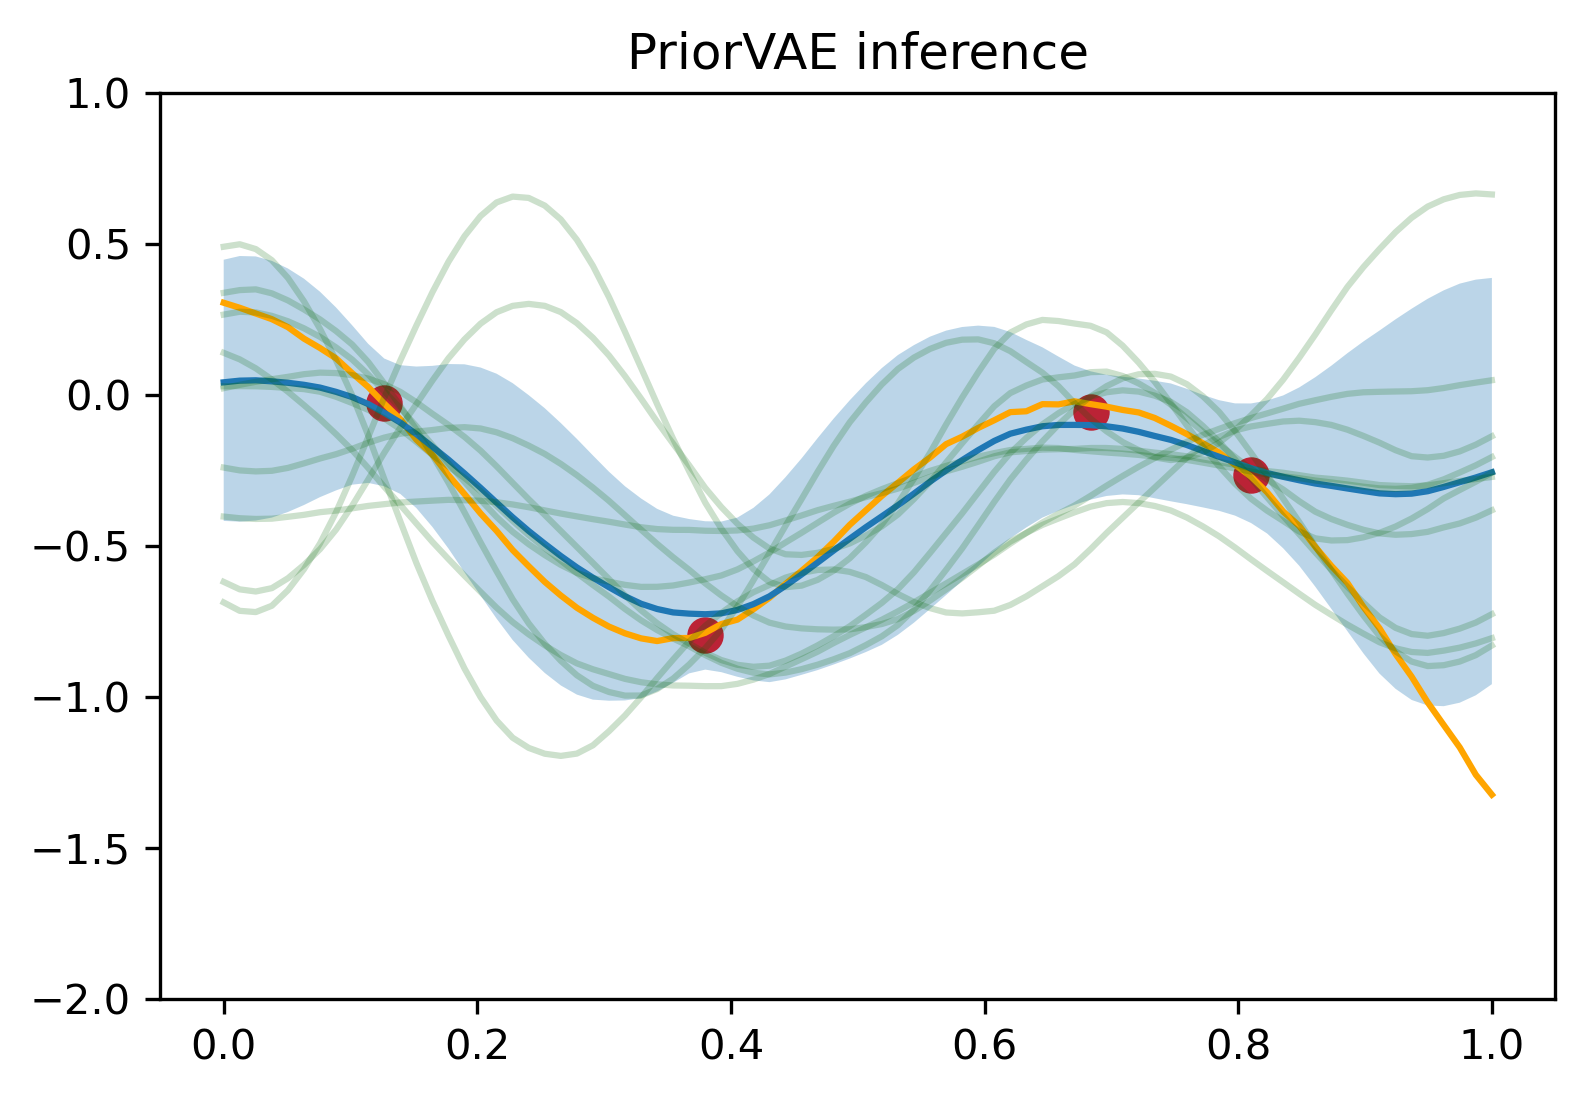

In [70]:
predictive = Predictive(numpyro_model, mcmc_vae_samples)
predictions_vae = predictive(rng_key_pred,  args["z_dim"], False, args["y_obs"], args["obs_idx"] )["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")

plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, label="VAE posterior: 90% BCI")
for j in range(N_lines):
    itr = int(predictions_vae.shape[0]/N_lines)
    #plt.plot(x, predictions_vae[j* itr,:], alpha=0.2, color="darkgreen", label="")
    plt.plot(x, predictions_vae[j,:], alpha=0.2, color="darkgreen", label="")

plt.title('PriorVAE inference')
#plt.legend(loc=1)
plt.ylim([-2, 1])

## Compare VAE and CVAE

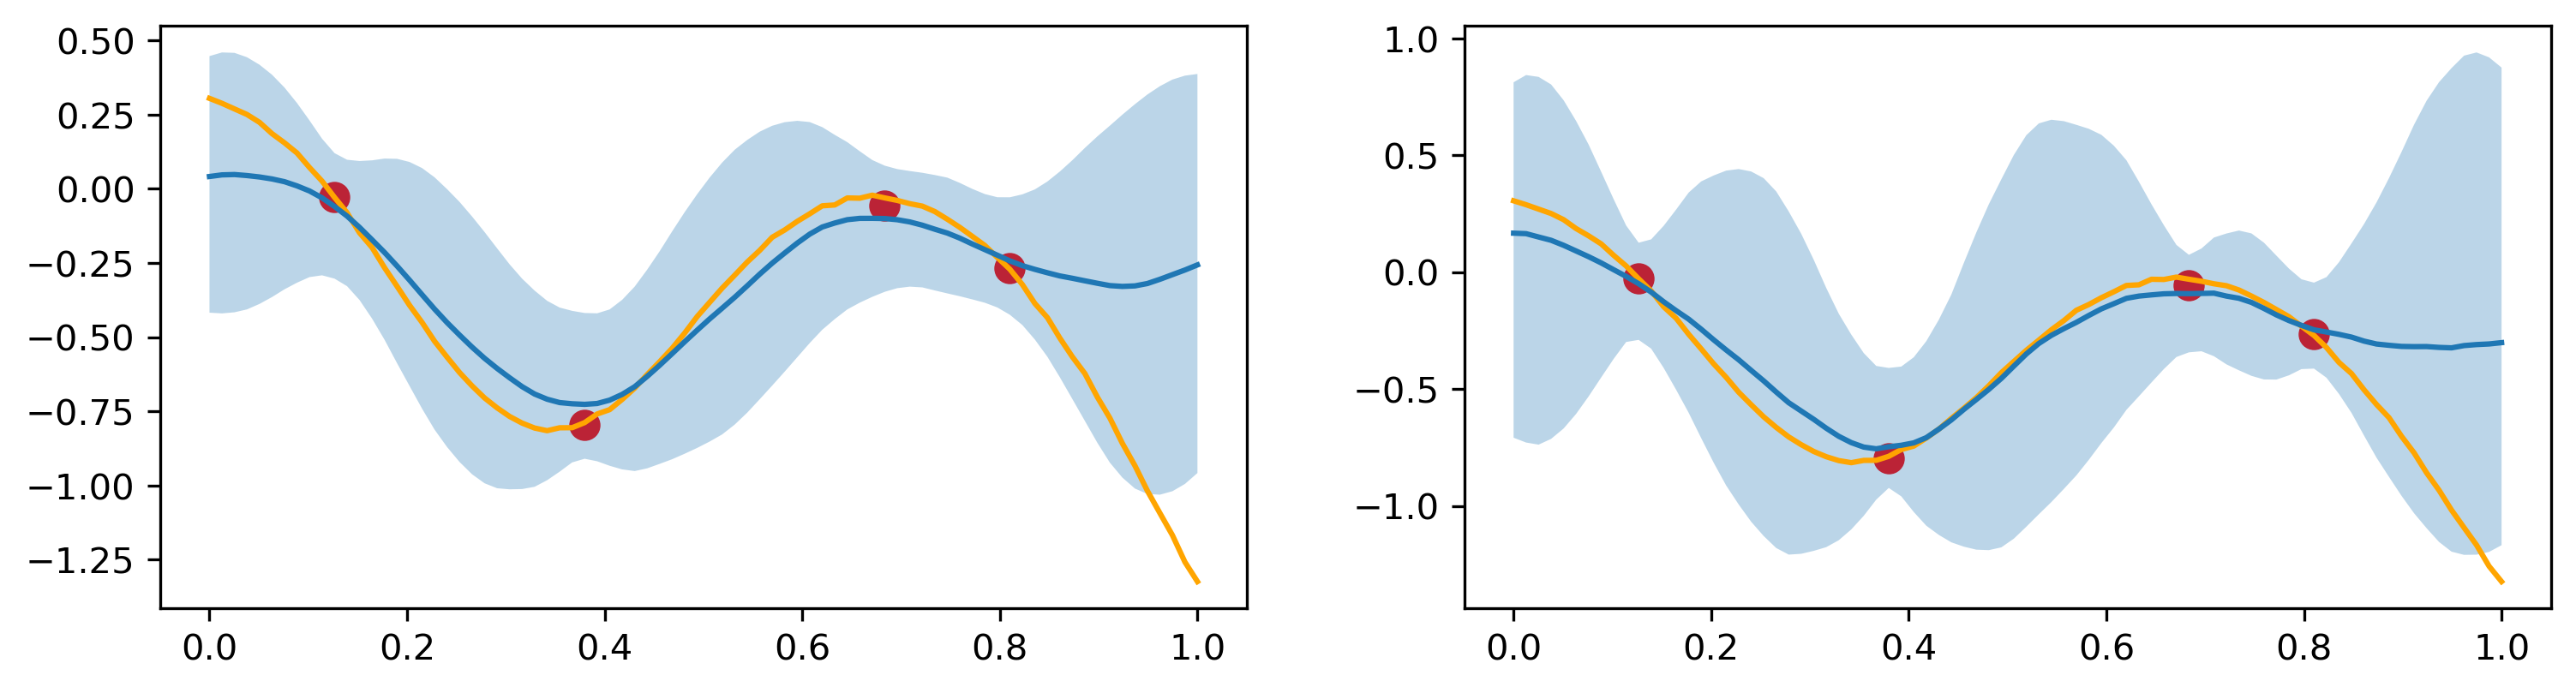

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

# VAE
axs[0].plot(x, gp_draw, label="ground truth", color="orange")
axs[0].scatter(x_obs, y_obs, color="red", label="observed data", s=60)
axs[0].plot(x, mean_post_pred_vae, label="predicted mean VAE")

axs[0].fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, label="VAE posterior: 90% BCI")
#for j in range(N_lines):
#    itr = int(predictions_vae.shape[0]/N_lines)
#    axs[0].plot(x, predictions_vae[j* itr,:], alpha=0.2, color="darkgreen", label="")

    
# CVAE    
axs[1].plot(x, gp_draw, label="ground truth", color="orange")
axs[1].scatter(x_obs, y_obs, color="red", label="observed data", s=60)
axs[1].plot(x, mean_post_pred_cvae, label="predicted mean CVAE")

axs[1].fill_between(x, percentiles_cvae[0, :], percentiles_cvae[1, :], alpha=0.3, interpolate=True, label="CVAE posterior: 90% BCI")
#for j in range(N_lines):
#    itr = int(predictions_cvae.shape[0]/N_lines)
#    axs[1].plot(x, predictions_cvae[j* itr,:], alpha=0.2, color="darkgreen", label="")
    
    
    

## Compare with GP

In [72]:
import dill

In [73]:
fname = "mcmc/gp1d_n80_niter55000.pkl"

In [74]:
with open(fname, 'rb') as f:
    mcmc_gp = dill.load(f)

In [75]:
mcmc_gp.print_summary(exclude_deterministic=False)    
mcmc_gp_samples = mcmc_gp.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      0.18      0.66      0.22     -0.91      1.22   2776.30      1.00
      f[1]      0.16      0.63      0.20     -0.87      1.16   2586.99      1.00
      f[2]      0.15      0.60      0.19     -0.84      1.07   2411.90      1.00
      f[3]      0.13      0.56      0.17     -0.78      0.99   2208.65      1.00
      f[4]      0.11      0.52      0.15     -0.72      0.90   1980.23      1.00
      f[5]      0.08      0.47      0.13     -0.65      0.79   1863.51      1.00
      f[6]      0.06      0.41      0.10     -0.57      0.68   1752.49      1.00
      f[7]      0.03      0.35      0.07     -0.50      0.53   1686.99      1.00
      f[8]      0.01      0.27      0.03     -0.43      0.38   1659.87      1.00
      f[9]     -0.02      0.19     -0.00     -0.32      0.26   1684.39      1.00
     f[10]     -0.05      0.13     -0.03     -0.27      0.14   1723.69      1.00
     f[11]     -0.09      0

In [76]:
ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
r = np.mean(ss['f']['n_eff'])
print("Average ESS for all GP effects : " + str(round(r)))

Average ESS for all GP effects : 1496


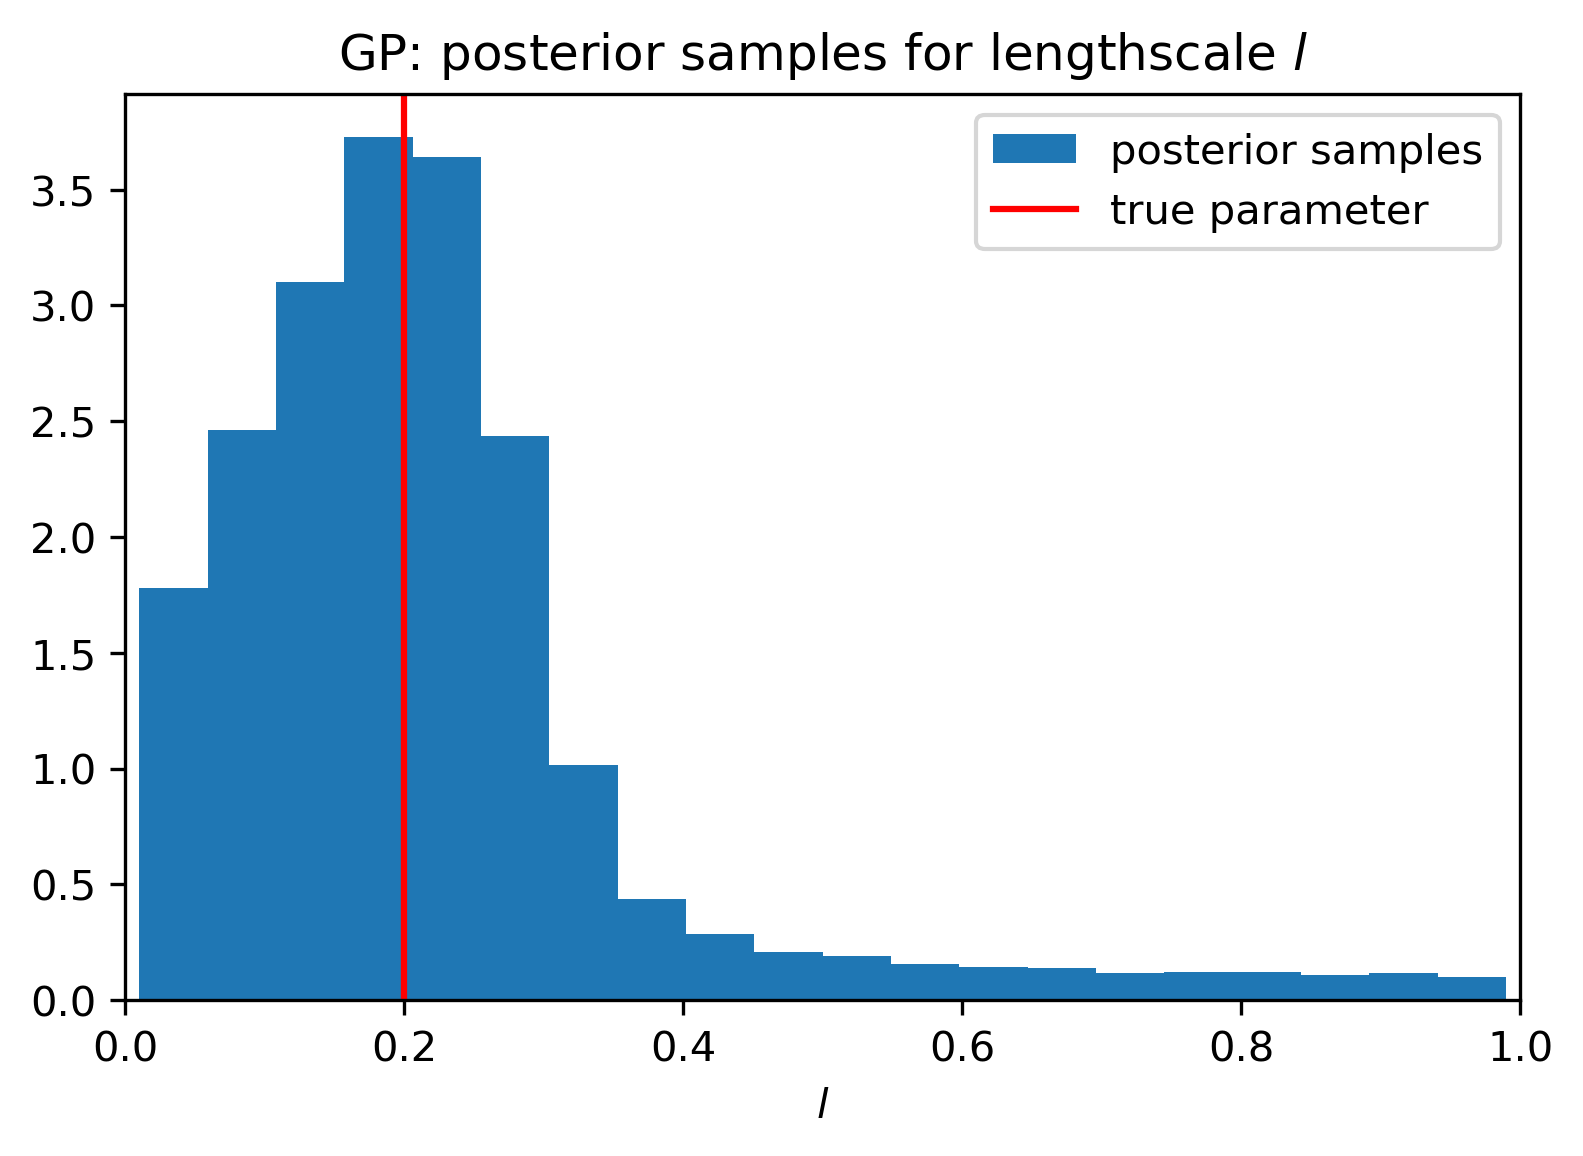

In [77]:
ls_samps = mcmc_gp_samples['length']
plt.hist(ls_samps, density=True, label = 'posterior samples', bins=20)
plt.axvline(x = args["true_ls"], color = 'red', label = 'true parameter')
plt.xlim(0,1)
plt.title('GP: posterior samples for lengthscale $l$')
plt.legend()
plt.xlabel('$l$')
#plt.show()

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_continuous_inference_GP_ls.pdf'.format(n))

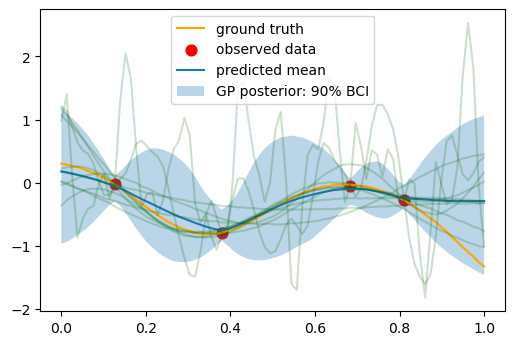

In [78]:
predictions_gp = mcmc_gp_samples['f']

mean_post_pred_gp = jnp.mean(predictions_gp, axis=0)
hpdi_post_pred_gp = hpdi(predictions_gp, 0.9)
percentiles_gp = np.percentile(predictions_gp, [5.0, 95.0], axis=0)

N_lines = 10
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_gp, label="predicted mean")
plt.fill_between(x, percentiles_gp[0, :], percentiles_gp[1, :], alpha=0.3, interpolate=True, label="GP posterior: 90% BCI")
for j in range(N_lines):
    itr = int(predictions_gp.shape[0]/N_lines)
    plt.plot(x, predictions_gp[j* itr,:], alpha=0.2, color="darkgreen", label="")
    
plt.legend()

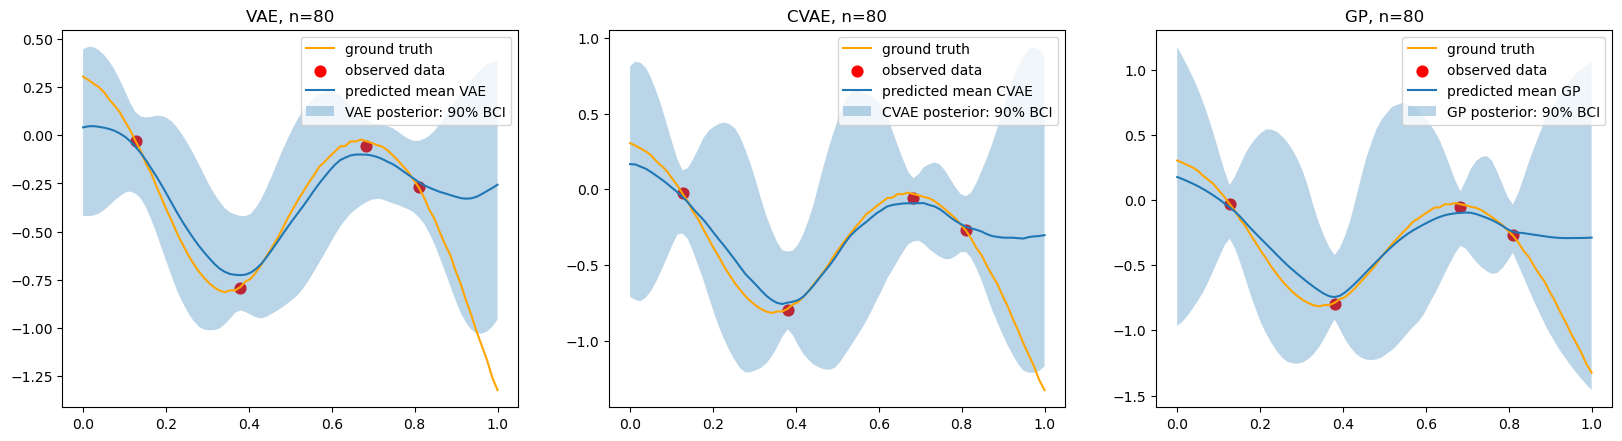

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# VAE
axs[0].plot(x, gp_draw, label="ground truth", color="orange")
axs[0].scatter(x_obs, y_obs, color="red", label="observed data", s=60)
axs[0].plot(x, mean_post_pred_vae, label="predicted mean VAE")

axs[0].fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, label="VAE posterior: 90% BCI")
#for j in range(N_lines):
#    itr = int(predictions_vae.shape[0]/N_lines)
#    axs[0].plot(x, predictions_vae[j* itr,:], alpha=0.2, color="darkgreen", label="")
axs[0].set_title("VAE, n=80")
axs[0].legend()

    
# CVAE    
axs[1].plot(x, gp_draw, label="ground truth", color="orange")
axs[1].scatter(x_obs, y_obs, color="red", label="observed data", s=60)
axs[1].plot(x, mean_post_pred_cvae, label="predicted mean CVAE")
axs[1].fill_between(x, percentiles_cvae[0, :], percentiles_cvae[1, :], alpha=0.3, interpolate=True, label="CVAE posterior: 90% BCI")
#for j in range(N_lines):
#    itr = int(predictions_cvae.shape[0]/N_lines)
#    axs[1].plot(x, predictions_cvae[j* itr,:], alpha=0.2, color="darkgreen", label="")
axs[1].set_title("CVAE, n=80")
axs[1].legend()


# GP
axs[2].plot(x, gp_draw, label="ground truth", color="orange")
axs[2].scatter(x_obs, y_obs, color="red", label="observed data", s=60)
axs[2].plot(x, mean_post_pred_gp, label="predicted mean GP")
axs[2].fill_between(x, percentiles_gp[0, :], percentiles_gp[1, :], alpha=0.3, interpolate=True, label="GP posterior: 90% BCI")
#for j in range(N_lines):
#    itr = int(predictions_gp.shape[0]/N_lines)
#    axs[2].plot(x, predictions_gp[j* itr,:], alpha=0.2, color="darkgreen", label="")
axs[2].set_title("GP, n=80")
axs[2].legend()
    
    
    

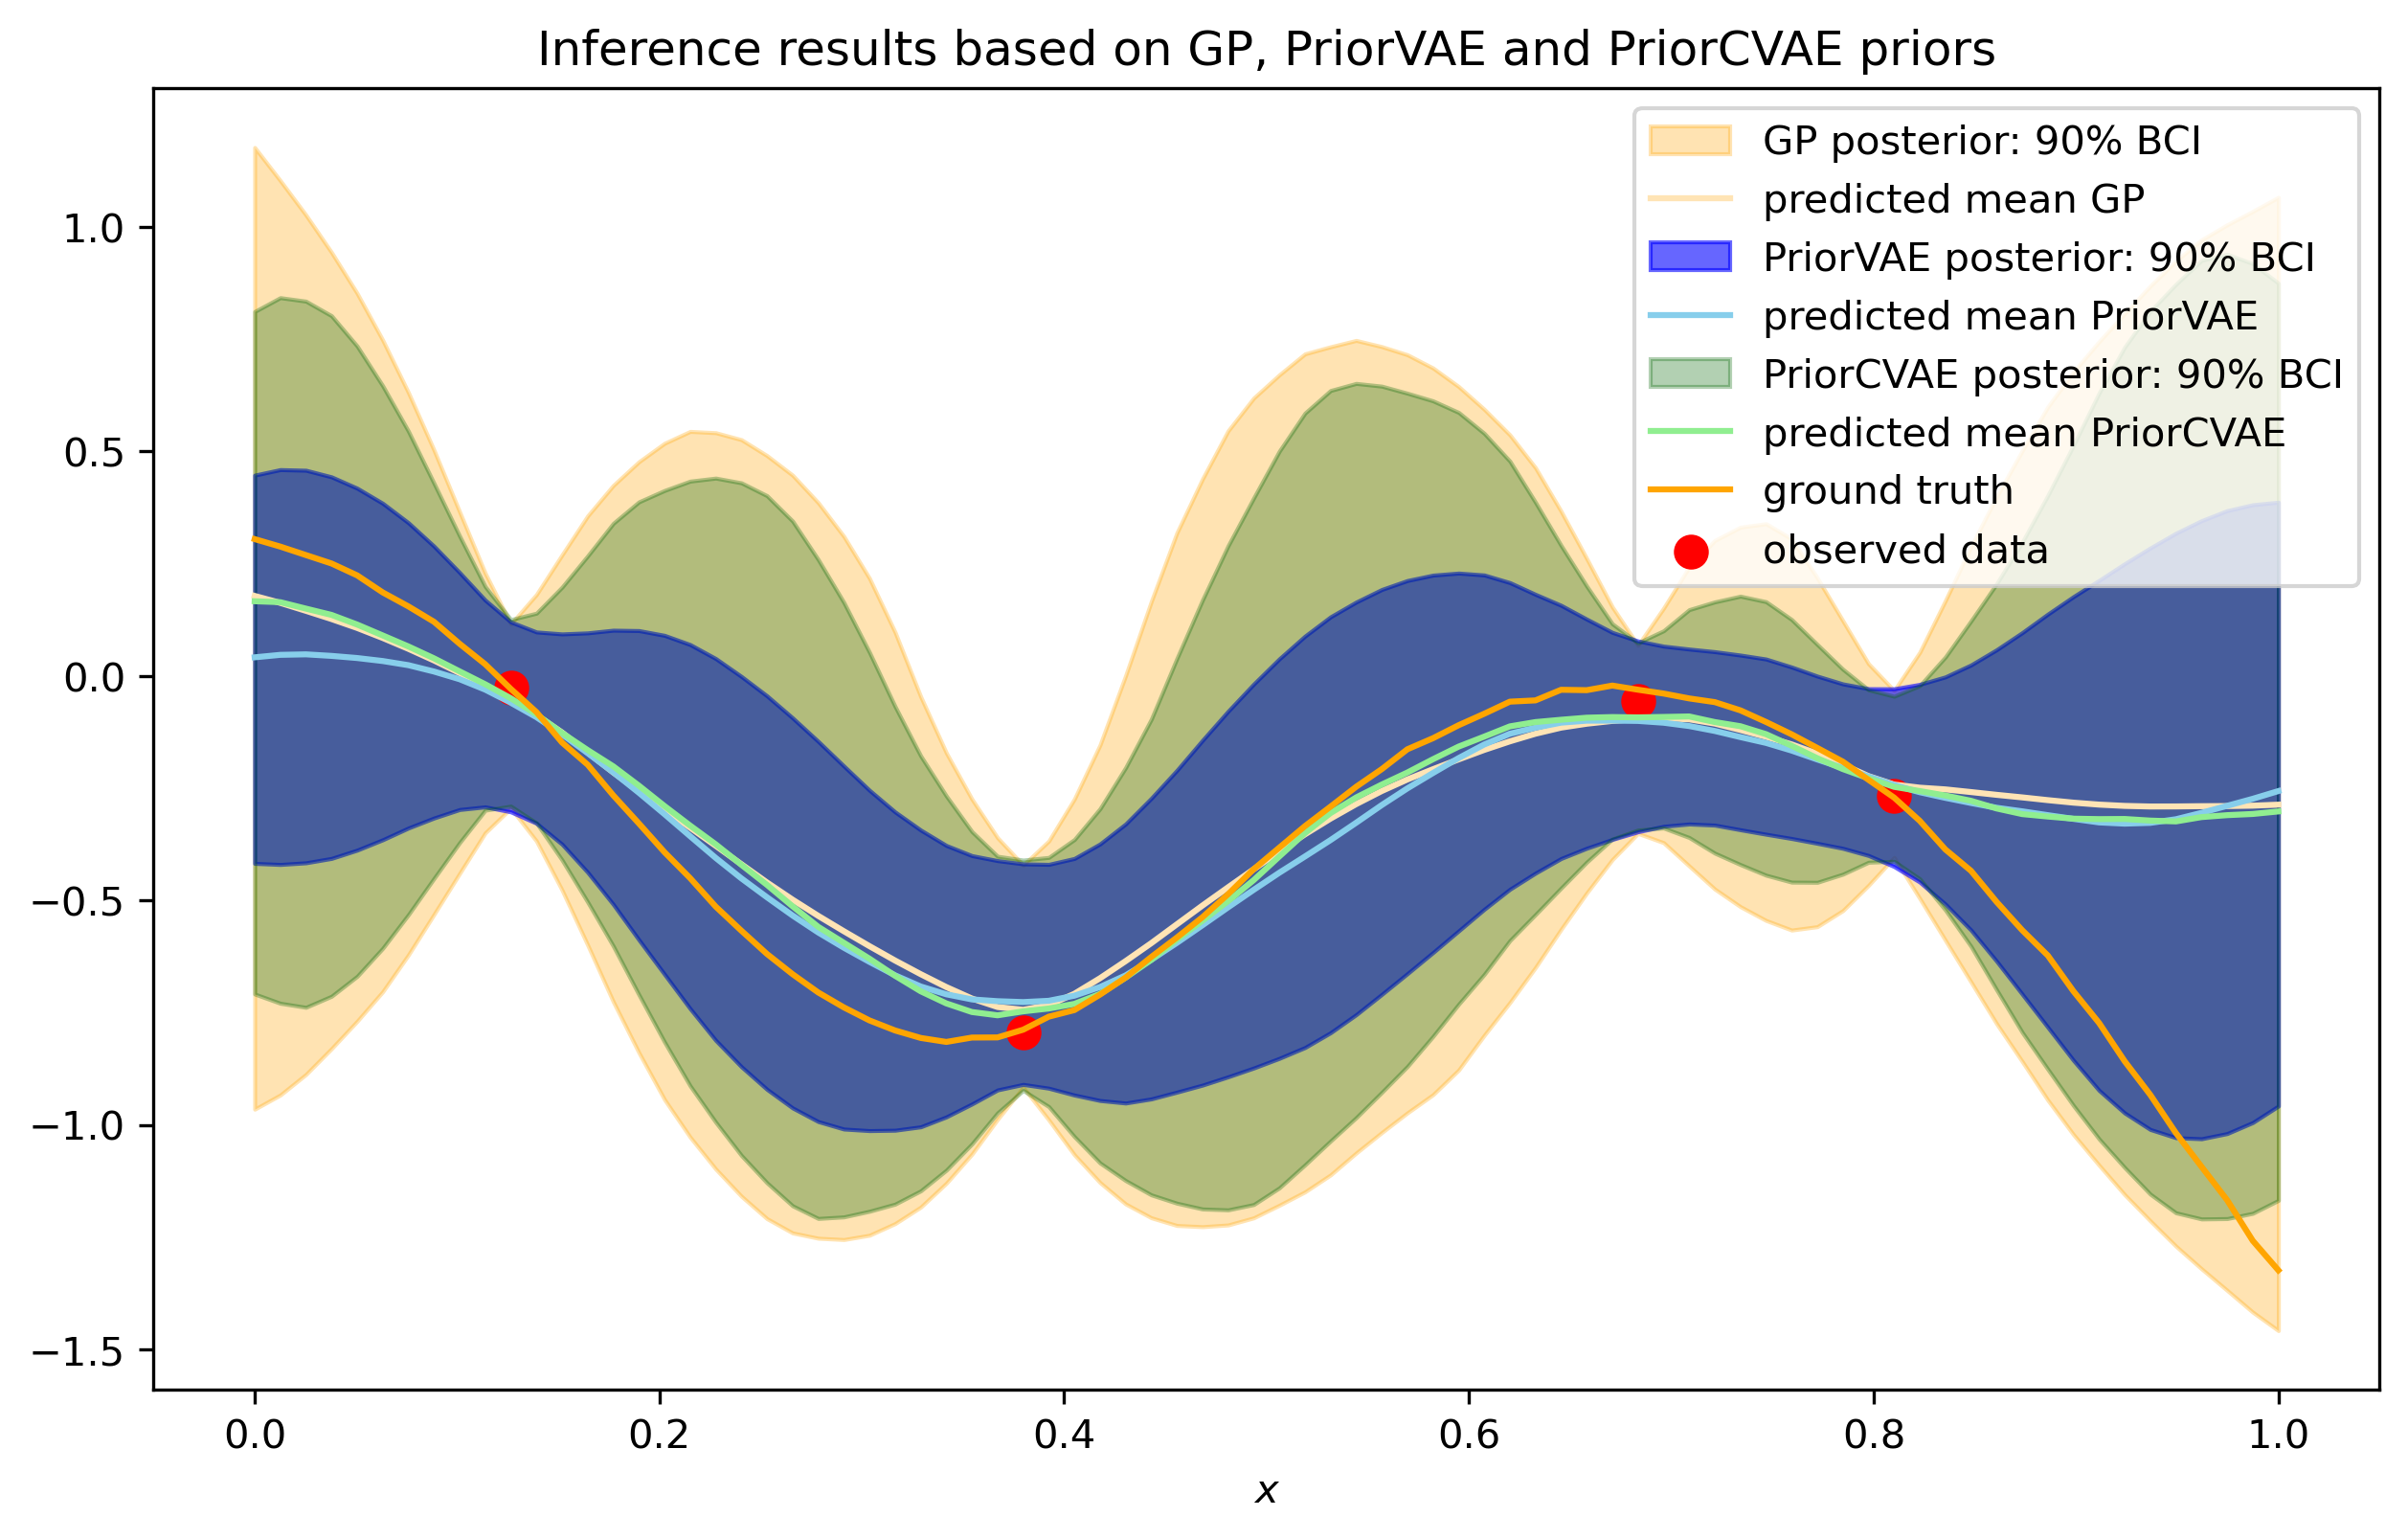

In [90]:
plt.rcParams["figure.figsize"] = (10,6)

plt.fill_between(x, percentiles_gp[0, :], percentiles_gp[1, :], color='orange', alpha=0.3, interpolate=True, label="GP posterior: 90% BCI")
plt.plot(x, mean_post_pred_gp, color='moccasin', label="predicted mean GP")

plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], color='blue', alpha=0.6, interpolate=True, label="PriorVAE posterior: 90% BCI")
plt.plot(x, mean_post_pred_vae, color='skyblue', label="predicted mean PriorVAE")

plt.fill_between(x, percentiles_cvae[0, :], percentiles_cvae[1, :], color='darkgreen', alpha=0.3, interpolate=True, label="PriorCVAE posterior: 90% BCI")
plt.plot(x, mean_post_pred_cvae, color='lightgreen',label="predicted mean PriorCVAE")

plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)

plt.title('Inference results based on GP, PriorVAE and PriorCVAE priors')
plt.legend()
plt.xlabel('$x$')

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_VAE_CVAE_GP_mean_BCI.pdf'.format(n))


In [56]:
predictions_vae.shape

(150000, 80)

In [57]:
predictions_cvae.shape

(150000, 80)

In [58]:
predictions_gp.shape

(150000, 80)

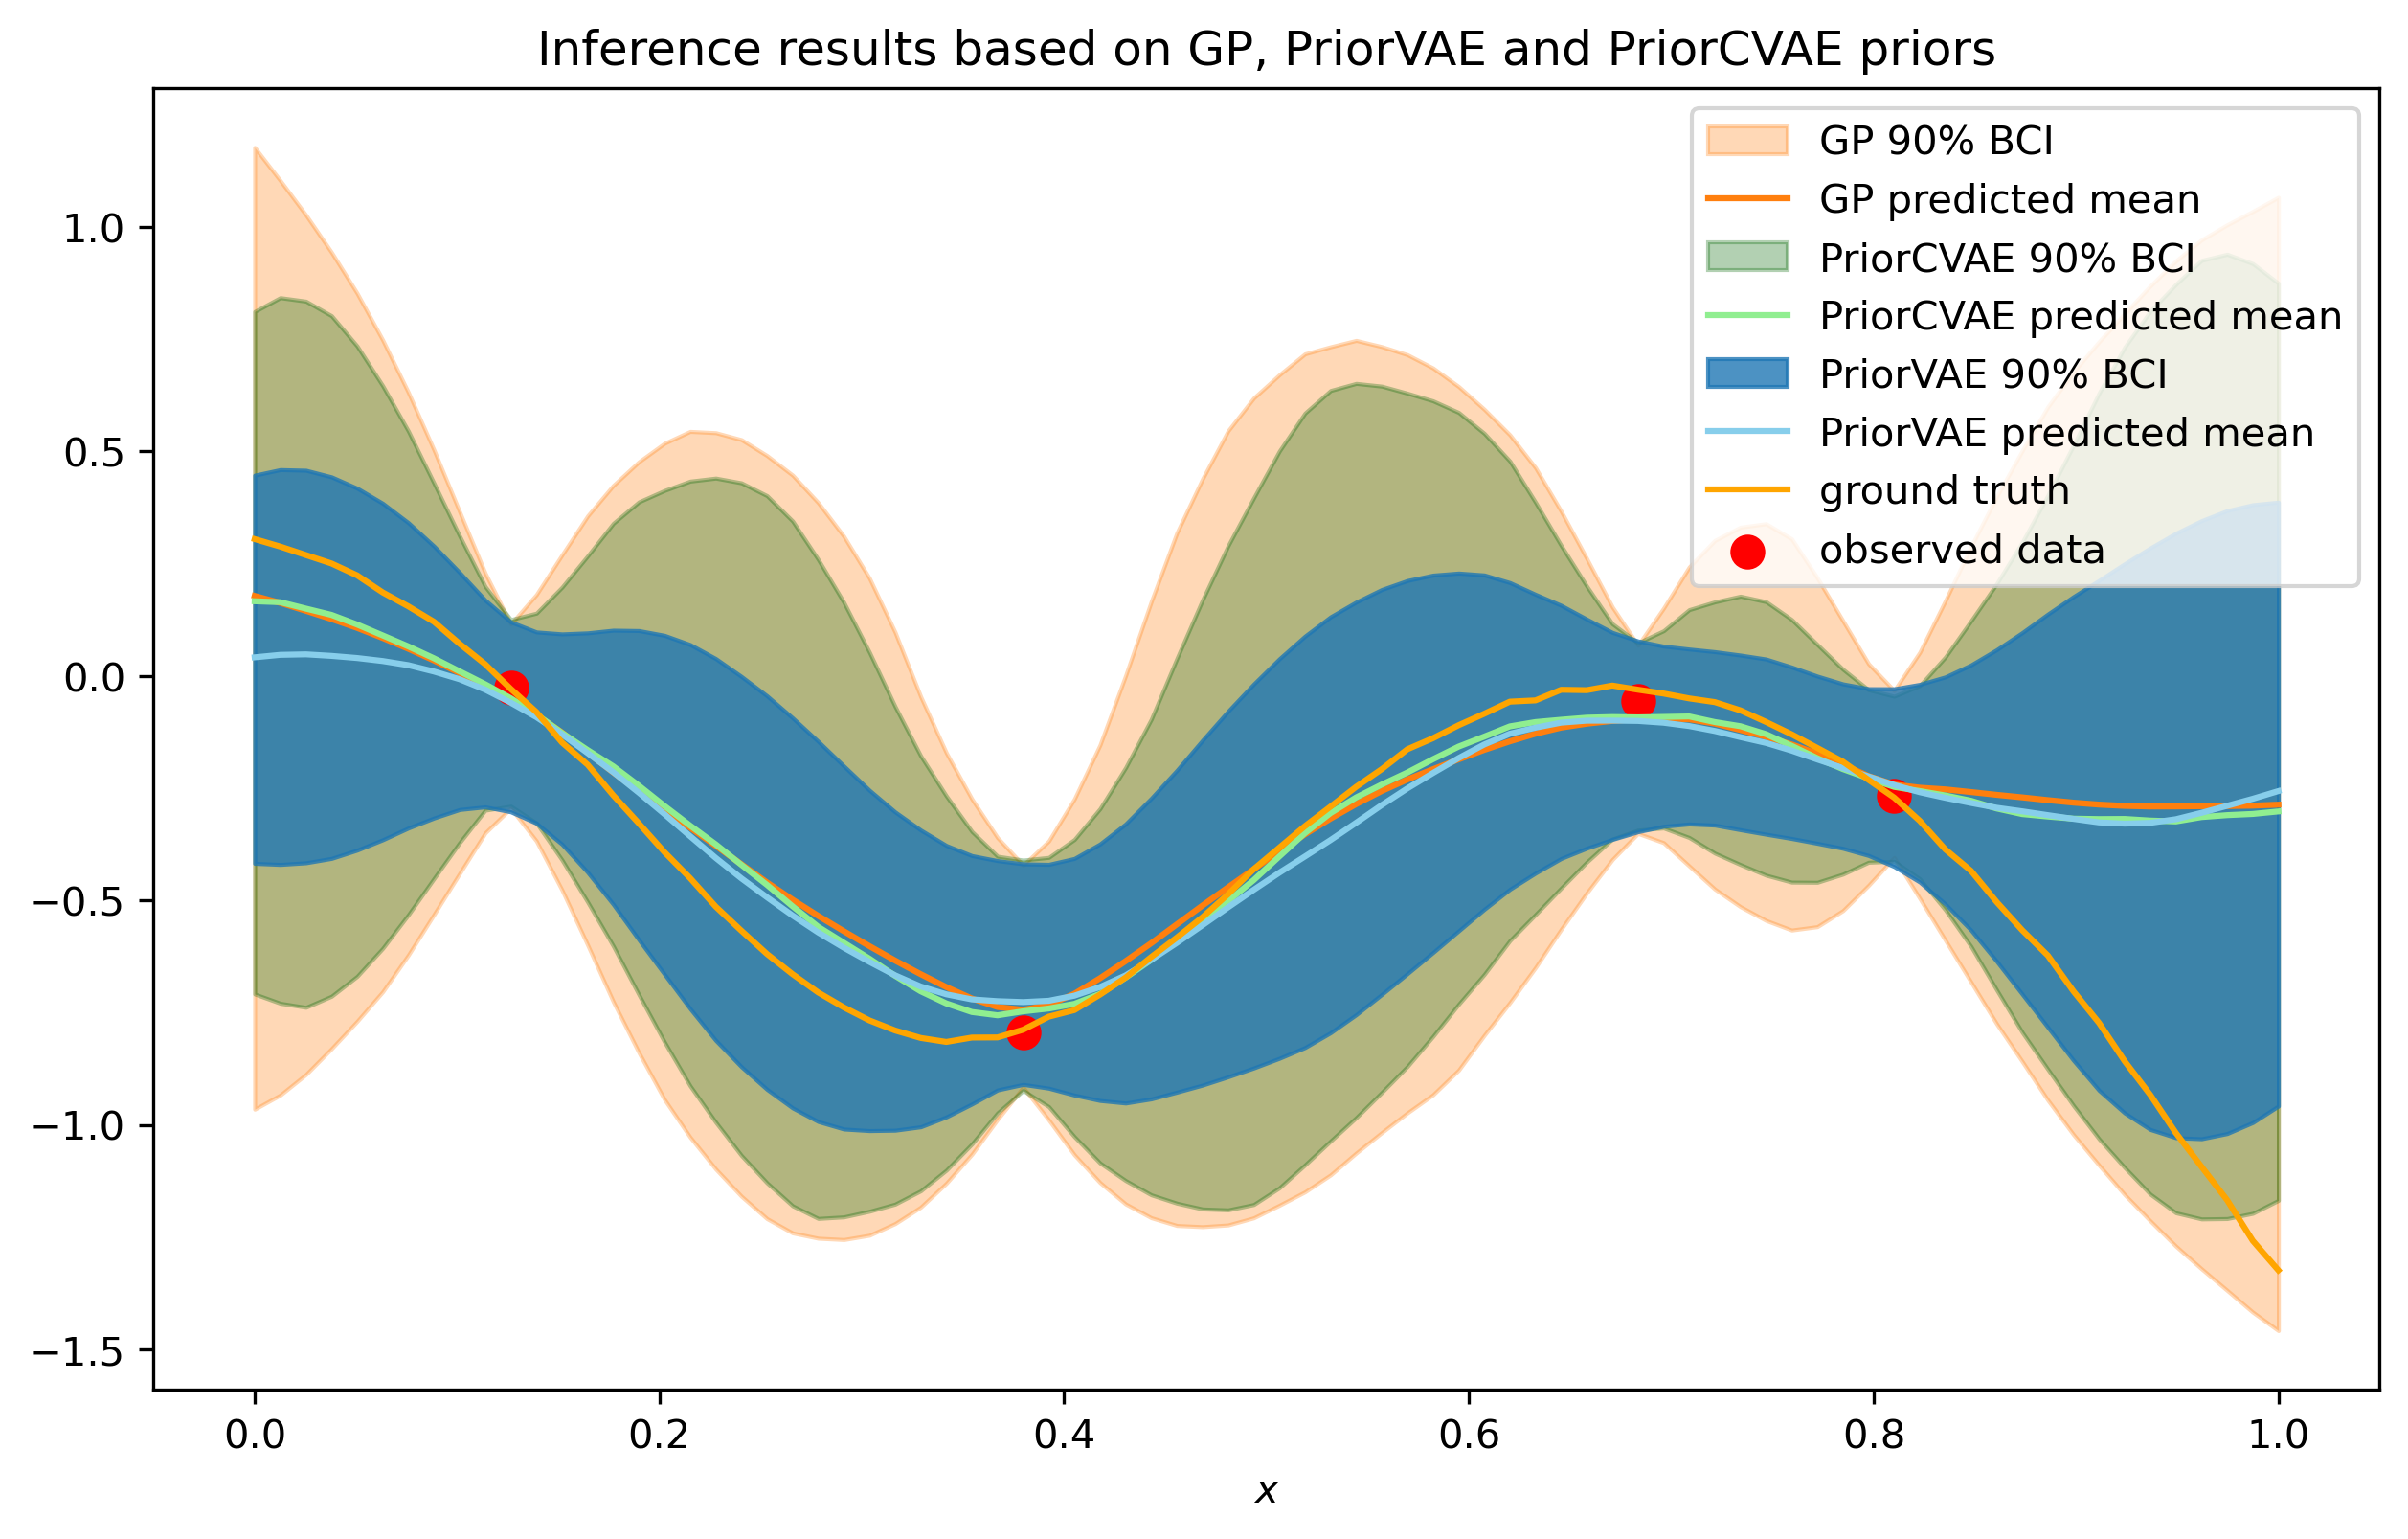

In [59]:
plt.rcParams["figure.figsize"] = (10,6)


# GP
plt.fill_between(x, percentiles_gp[0, :], percentiles_gp[1, :], color='#ff7f0e', 
                 alpha=0.3, interpolate=True, label="GP 90% BCI")
plt.plot(x, mean_post_pred_gp, color='#ff7f0e', 
         label="GP predicted mean")


# PrioCVAE
plt.fill_between(x, percentiles_cvae[0, :], percentiles_cvae[1, :], color='darkgreen', 
                 alpha=0.3, interpolate=True, label="PriorCVAE 90% BCI")
plt.plot(x, mean_post_pred_cvae, color='lightgreen',
         label="PriorCVAE predicted mean")

# PrioVAE
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], color='#1f77b4', 
                 alpha=0.8, interpolate=True, label="PriorVAE 90% BCI")
plt.plot(x, mean_post_pred_vae, color='skyblue', 
         label="PriorVAE predicted mean")

plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", 
            label="observed data", s=60)

plt.title('Inference results based on GP, PriorVAE and PriorCVAE priors')
plt.legend()
plt.xlabel('$x$')

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_VAE_CVAE_GP_mean_BCI.pdf'.format(n))

In [54]:
ls_samps = mcmc_gp_samples['length']
c_samps = mcmc_cvae_samples['c']

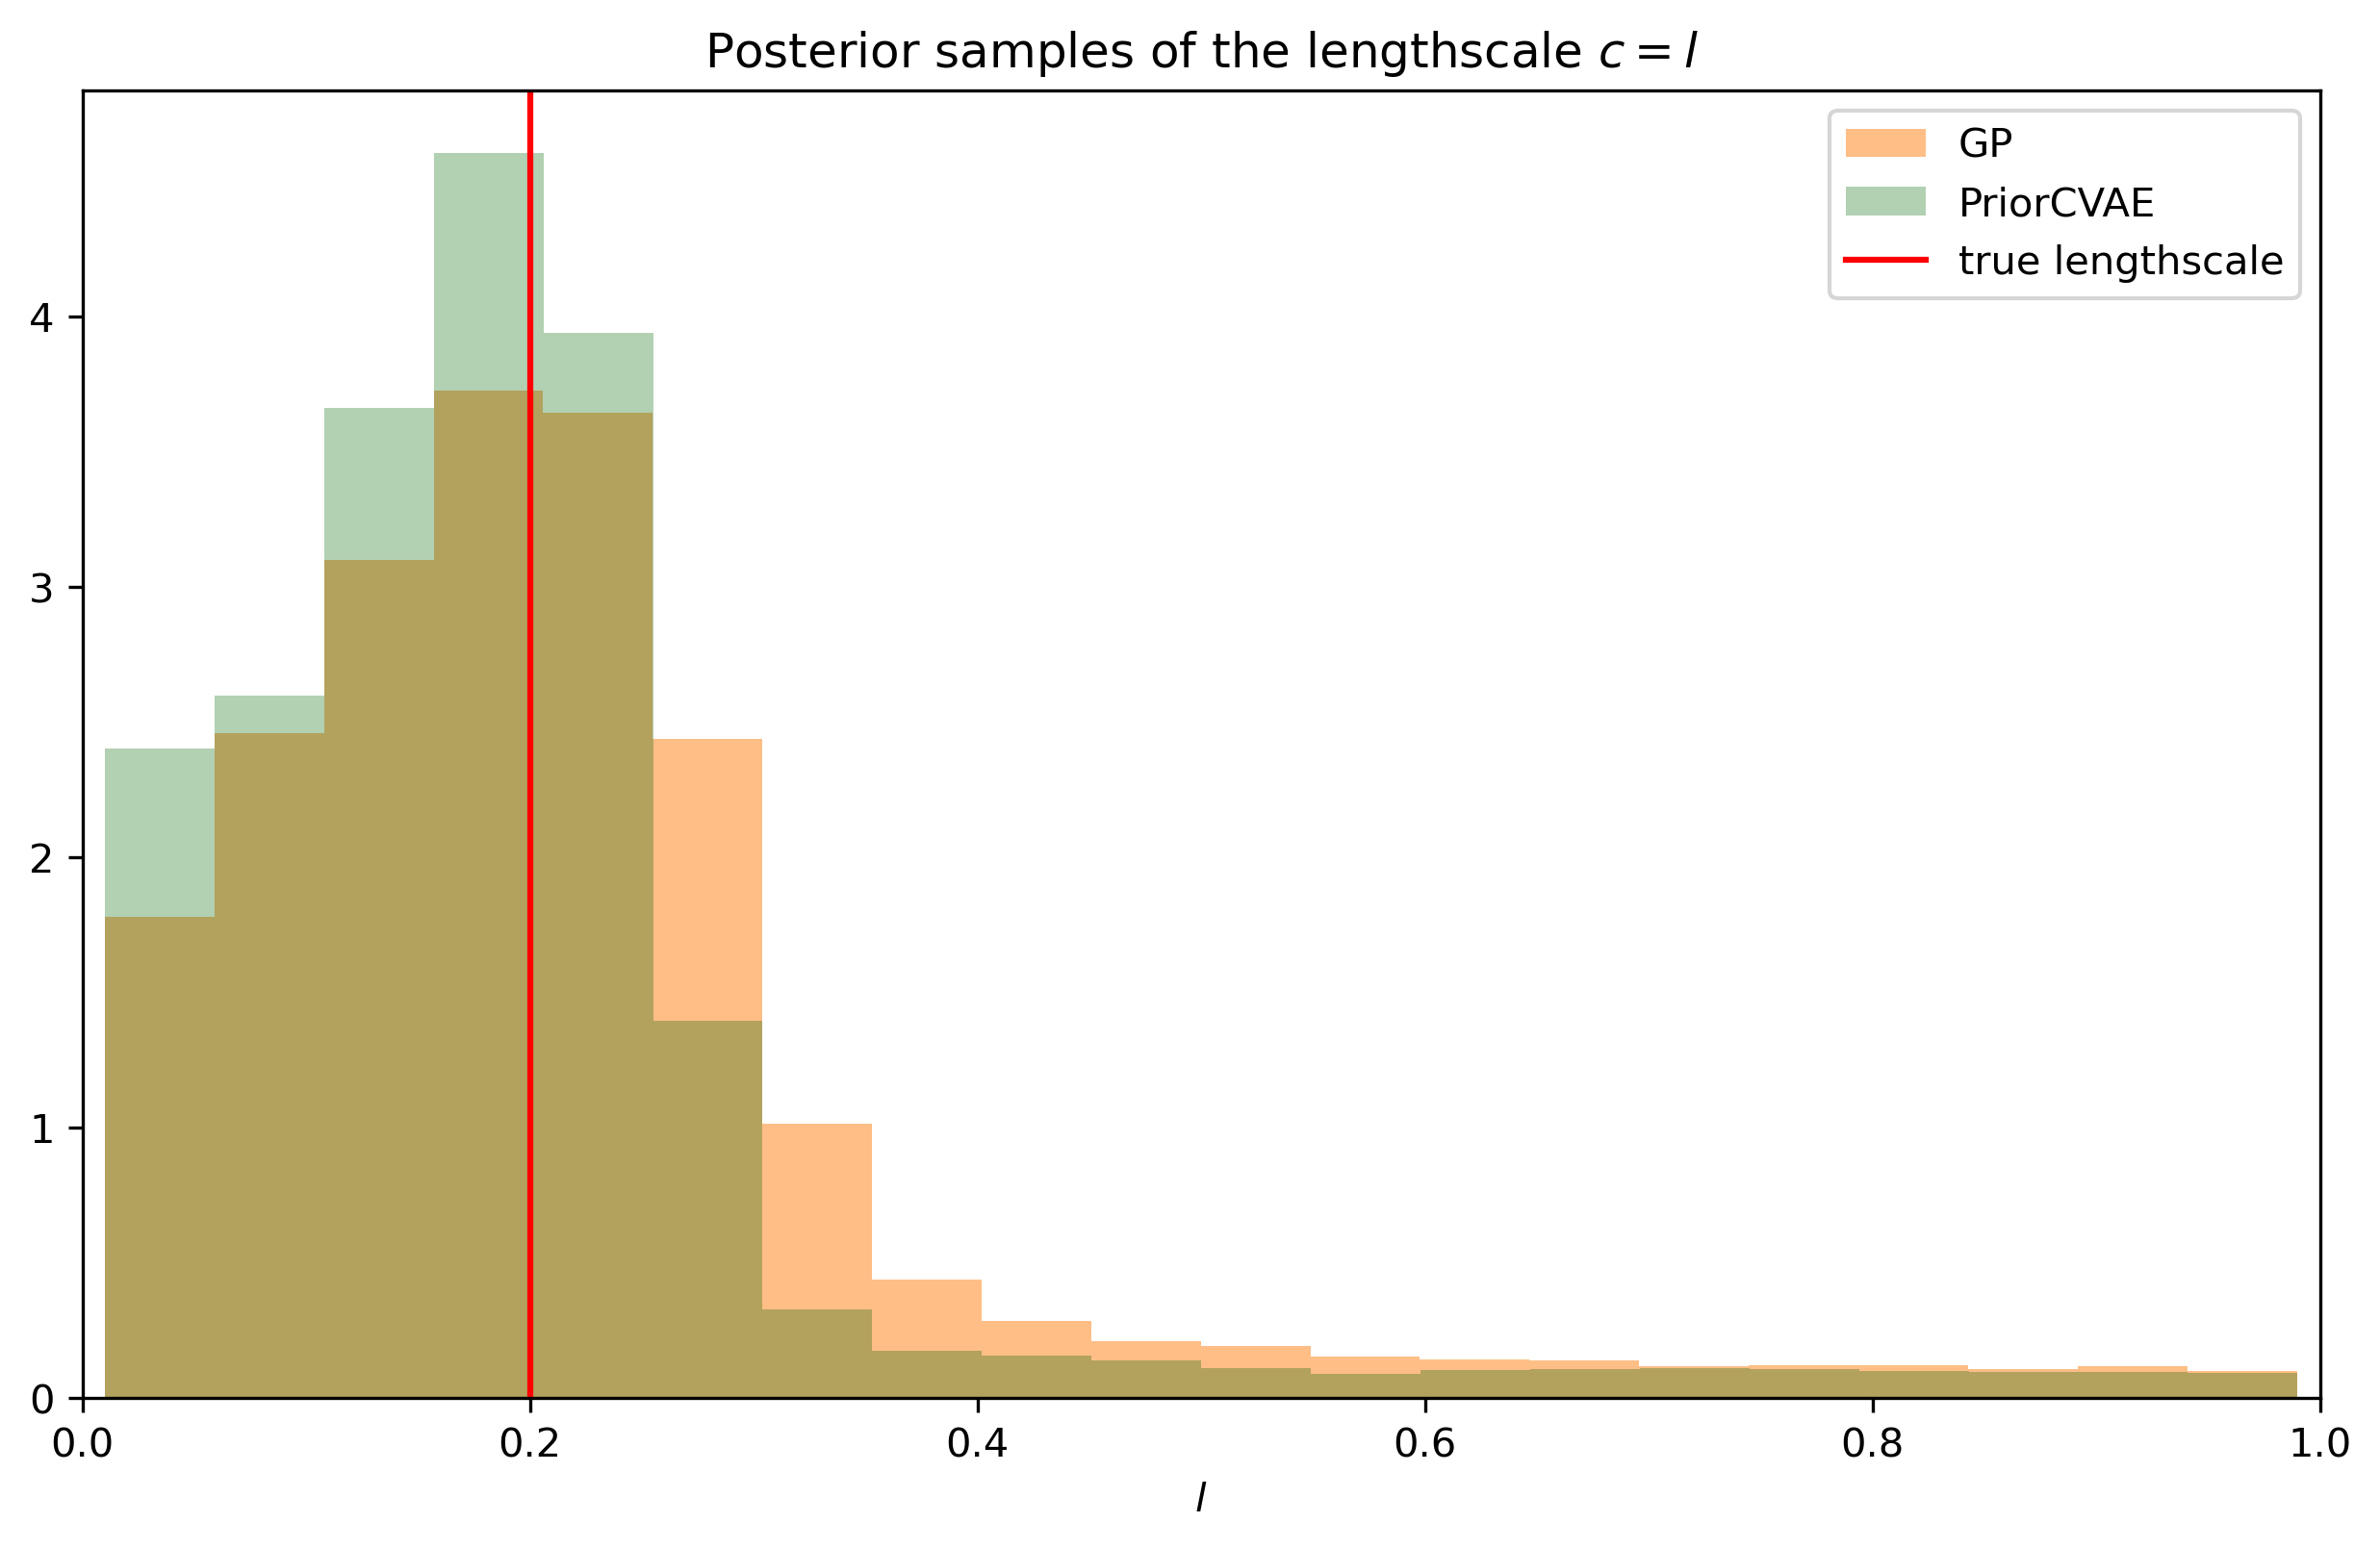

In [55]:
n_bins = 20

# GP
plt.hist(ls_samps, density=True, label = 'GP', bins=n_bins, color='#ff7f0e', alpha=0.5)

# PriorCVAE
#cvae_col = '#2ca02c'
cvae_col = 'darkgreen'
plt.hist(c_samps, density=True, label = 'PriorCVAE', bins=n_bins, color=cvae_col, alpha=0.3)


plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('Posterior samples of the lengthscale $c=l$')
plt.legend()
plt.xlabel('$l$')


n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_CVAE_GP_ls_hist.pdf'.format(n))

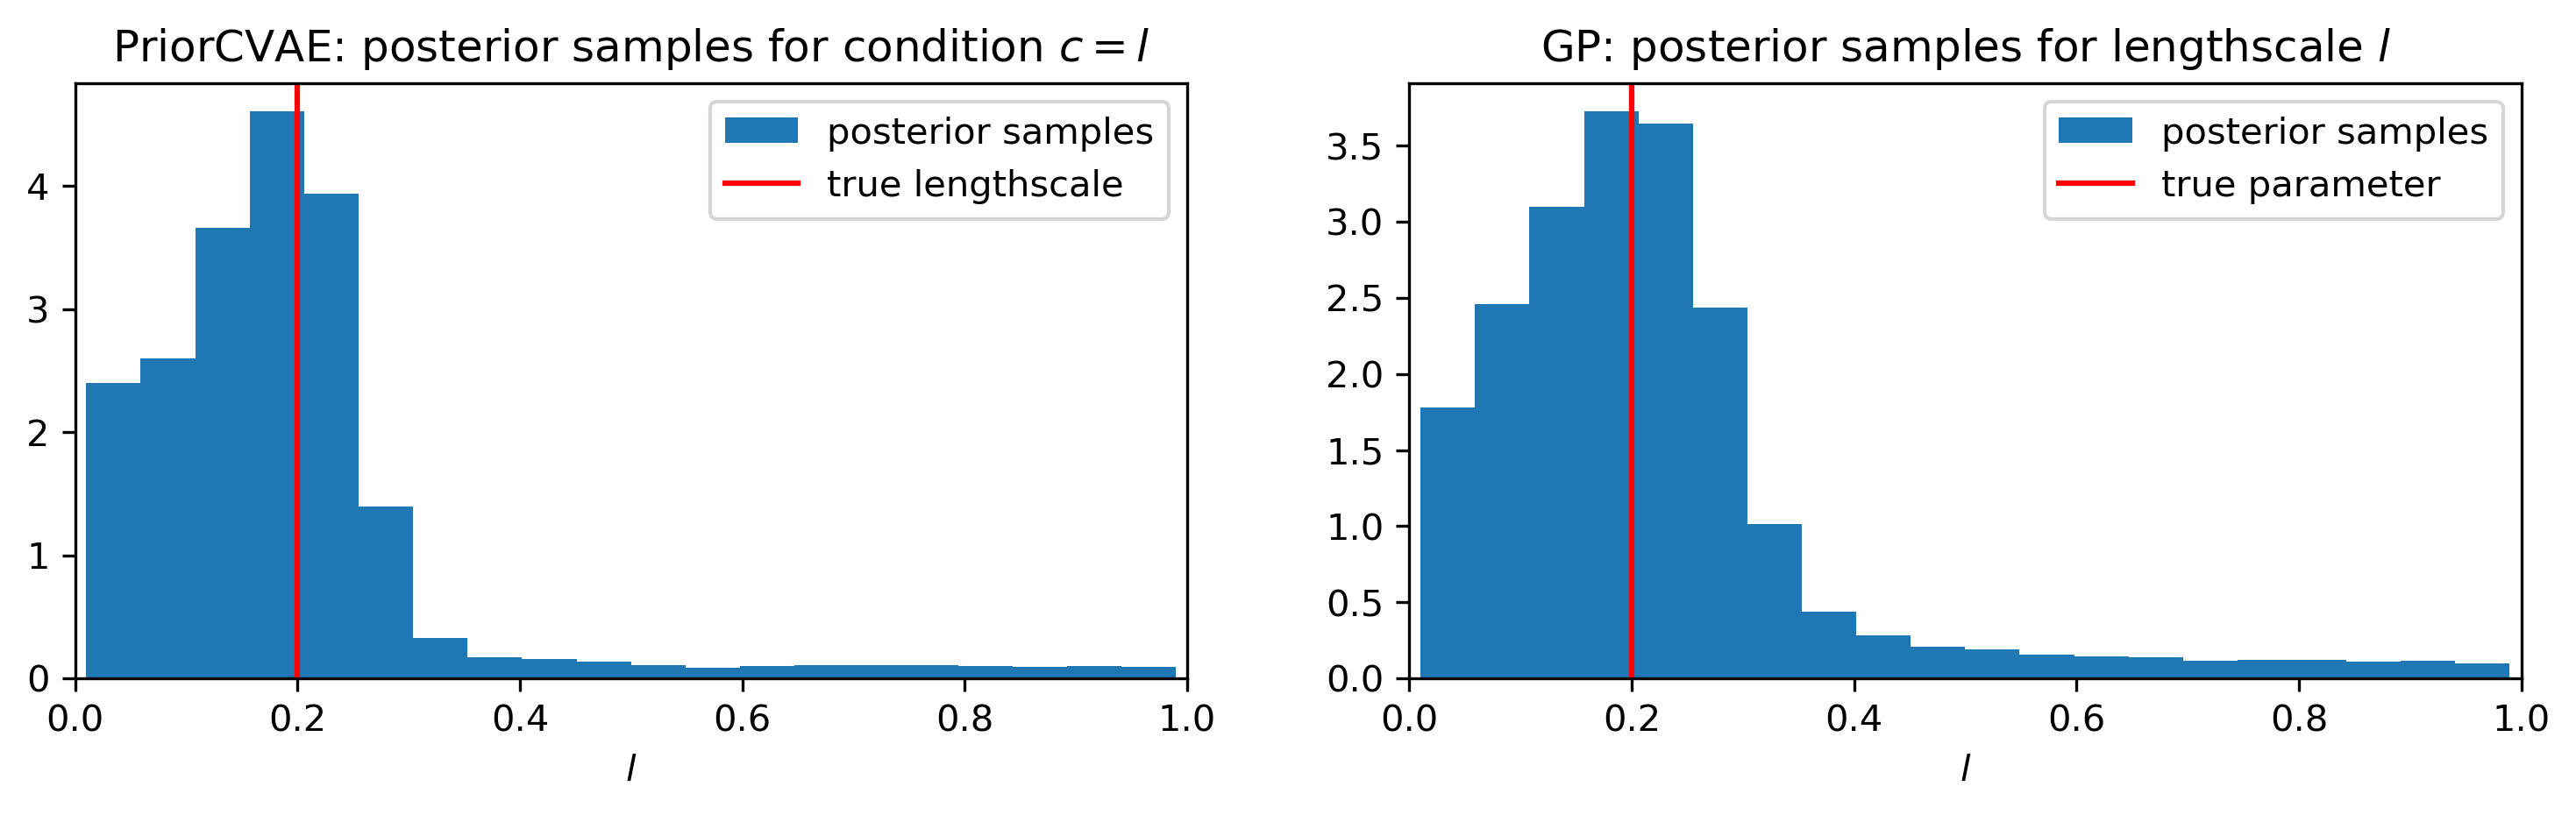

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

N_lines = 10

axs[0].hist(c_samps_cvae, density=True, label = 'posterior samples', bins=20)
axs[0].axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
axs[0].set_xlim(0,1)
axs[0].set_title('PriorCVAE: posterior samples for condition $c=l$')
axs[0].legend()
axs[0].set_xlabel('$l$')

axs[1].hist(ls_samps, density=True, label = 'posterior samples', bins=20)
axs[1].axvline(x = args["true_ls"], color = 'red', label = 'true parameter')
axs[1].set_xlim(0,1)
axs[1].set_title('GP: posterior samples for lengthscale $l$')
axs[1].legend()
axs[1].set_xlabel('$l$')

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('res/1d_n{}_CVAE_GP_ls_hist.pdf'.format(n))